In [14]:
import main
from data.seed_iv import FeatureMethod, Subject, Session
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold

config_file = main.parse_opt(['-c', 'local_template.json'])
data = main.parse_config(config_file)
config = main.Config(data)


Preprocess to get 
    x: all trail samples of one subject
    y: all labels of one subject


In [4]:
import scipy.io
import os

eeg_raw_data_path = os.path.join(
    config.dataset['root_path'],
    config.dataset['eeg_raw_data_path']
)

target_file = os.path.join(eeg_raw_data_path, '1', '1_20160518.mat')
data = scipy.io.loadmat(target_file)
data.pop('__header__', None)
data.pop('__version__', None)
data.pop('__globals__', None)

data = list(data.values())


In [5]:
eeg_feature_data_path = os.path.join(
    config.dataset['root_path'],
    config.dataset['eeg_feature_smooth_path']
)

target_feature_file = os.path.join(eeg_feature_data_path, '1', '1_20160518.mat')
feature_data = scipy.io.loadmat(target_feature_file)

feature_data.pop('__header__', None)
feature_data.pop('__version__', None)
feature_data.pop('__globals__', None)

[]

ANOVA

In [20]:
import pandas as pd

de_ma_1 = feature_data['psd_movingAve1']
de_ma_1 = np.array(de_ma_1)
unshaped = de_ma_1
# Frequency band and channel labels
freq_bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
channel_labels = [f'ch_{i+1}' for i in range(62)]

# Reshape data into a DataFrame
reshaped_data = []
for i, band in enumerate(freq_bands):
    for j, channel in enumerate(channel_labels):
        for t in range(unshaped.shape[1]):
            reshaped_data.append([unshaped[j, t, i], band, channel, t])

# Convert to DataFrame
df = pd.DataFrame(reshaped_data, columns=['EEG_value', 'Frequency_band', 'Channel', 'Time'])

import statsmodels.api as sm
from statsmodels.formula.api import ols

# Define the ANOVA model
model = ols('EEG_value ~ C(Frequency_band) + C(Channel) + C(Frequency_band):C(Channel)', data=df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                                    sum_sq       df            F  PR(>F)
C(Frequency_band)             7.123616e+14      4.0  4437.374801     0.0
C(Channel)                    4.081968e+14     61.0   166.734430     0.0
C(Frequency_band):C(Channel)  1.203928e+15    244.0   122.940818     0.0
Residual                      5.101055e+14  12710.0          NaN     NaN


In [ ]:
from scipy.stats import f_oneway

data = np.transpose(unshaped, (2, 0, 1)) # (62, 42, 5)
# Example 3D EEG data: (frequency bands, channels, time points)
# data = np.random.rand(5, 62, 1000)  # Simulated data for illustration

# Step 1: Average over channels and time points
# This reduces the data to a 1D array of averages per frequency band
data_avg = data.mean(axis=(1, 2))  # Shape: (5,)

# Step 2: Organize data by frequency bands for ANOVA
# If we were to perform ANOVA directly, we need data arrays per group (frequency band)
freq_band_data = [data[i].flatten() for i in range(5)]

# Step 3: Perform one-way ANOVA across frequency bands
anova_result = f_oneway(*freq_band_data)
    
# Output the ANOVA result
print("ANOVA result:", anova_result)
print("F-statistic:", anova_result.statistic)
print("p-value:", anova_result.pvalue)


ANOVA result: F_onewayResult(statistic=1092.1751945866547, pvalue=0.0)
F-statistic: 1092.1751945866547
p-value: 0.0


In [ ]:
from scipy.stats import f_oneway

# Example data setup
# data: [samples, features], e.g., each row is a sample's EEG feature vector
# labels: Emotion labels corresponding to each sample, e.g., [0, 1, 2, 3]

# Example data generation
num_samples = 100  # Total number of samples
num_features = 5   # Number of EEG features per sample
data = np.random.rand(num_samples, num_features)  # Random data for illustration
labels = np.random.randint(0, 4, num_samples)  # Random labels 0 to 3 for illustration

# Step 1: Organize data by emotion labels
emotion_groups = [data[labels == i] for i in range(4)]  # Creates 4 groups based on labels

# Step 2: Perform ANOVA on each feature across emotion groups
anova_results = []
for feature_idx in range(num_features):
    # Extract the feature column across all groups
    feature_data = [group[:, feature_idx] for group in emotion_groups]
    
    # Perform ANOVA across the four emotion groups
    anova_result = f_oneway(*feature_data)
    anova_results.append((feature_idx, anova_result.statistic, anova_result.pvalue))

# Output the ANOVA results
for feature_idx, f_stat, p_value in anova_results:
    print(f"Feature {feature_idx}: F-statistic = {f_stat}, p-value = {p_value}")


Frequency Band 1: F-statistic = 0.4399, p-value = 7.2463e-01
Frequency Band 2: F-statistic = 1.7447, p-value = 1.5805e-01
Frequency Band 3: F-statistic = 12.7819, p-value = 7.4575e-08
Frequency Band 4: F-statistic = 14.7589, p-value = 5.9637e-09
Frequency Band 5: F-statistic = 6.8068, p-value = 1.9150e-04


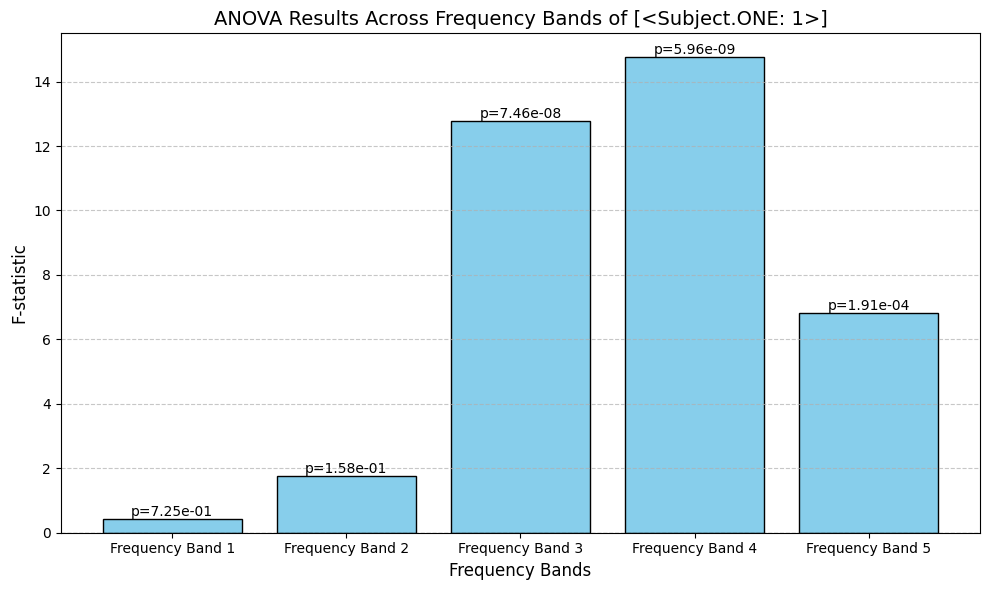

C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], pa

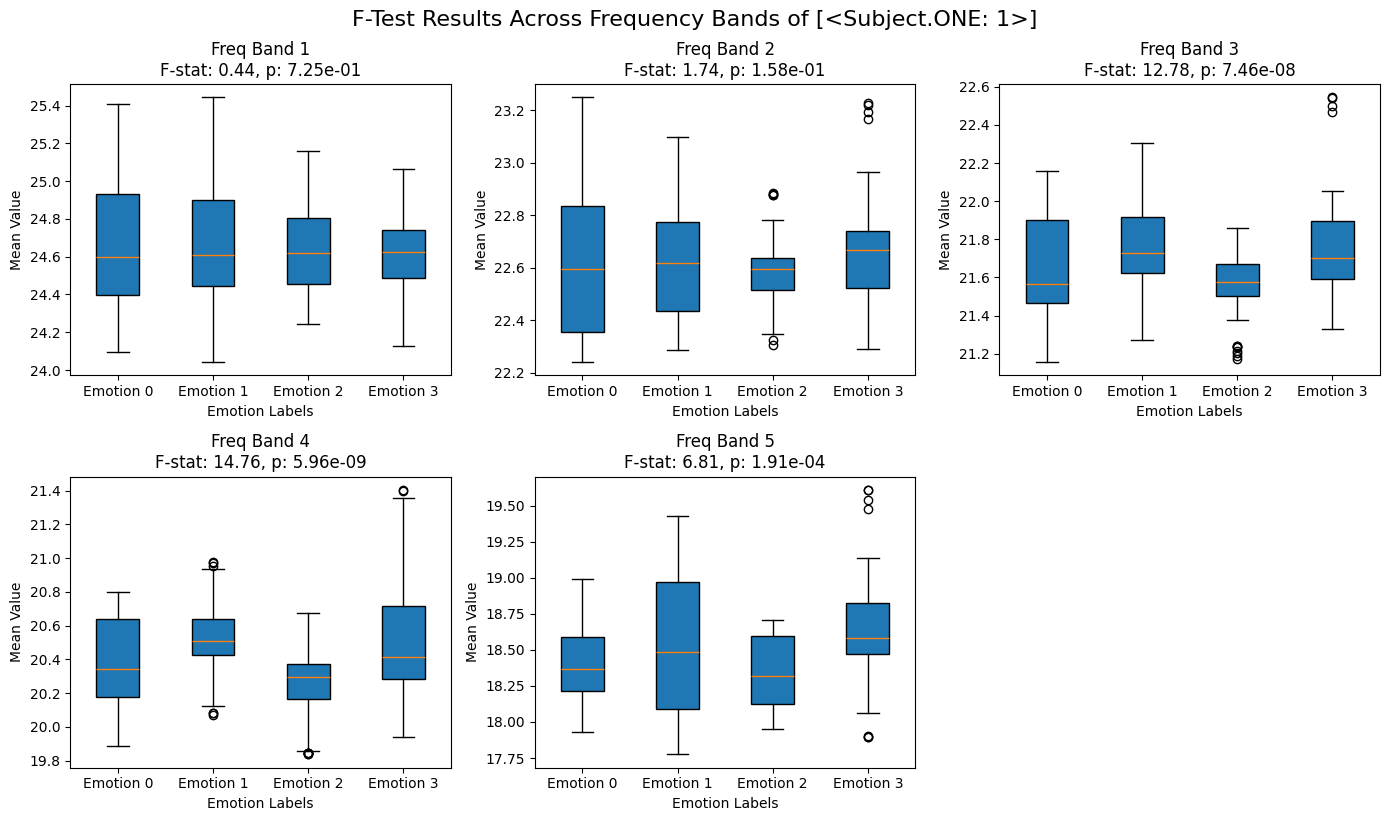

Frequency Band 1: F-statistic = 2.5041, p-value = 5.9467e-02
Frequency Band 2: F-statistic = 6.3855, p-value = 3.3635e-04
Frequency Band 3: F-statistic = 59.9628, p-value = 5.4147e-30
Frequency Band 4: F-statistic = 135.9695, p-value = 1.9781e-54
Frequency Band 5: F-statistic = 126.0243, p-value = 9.7947e-52


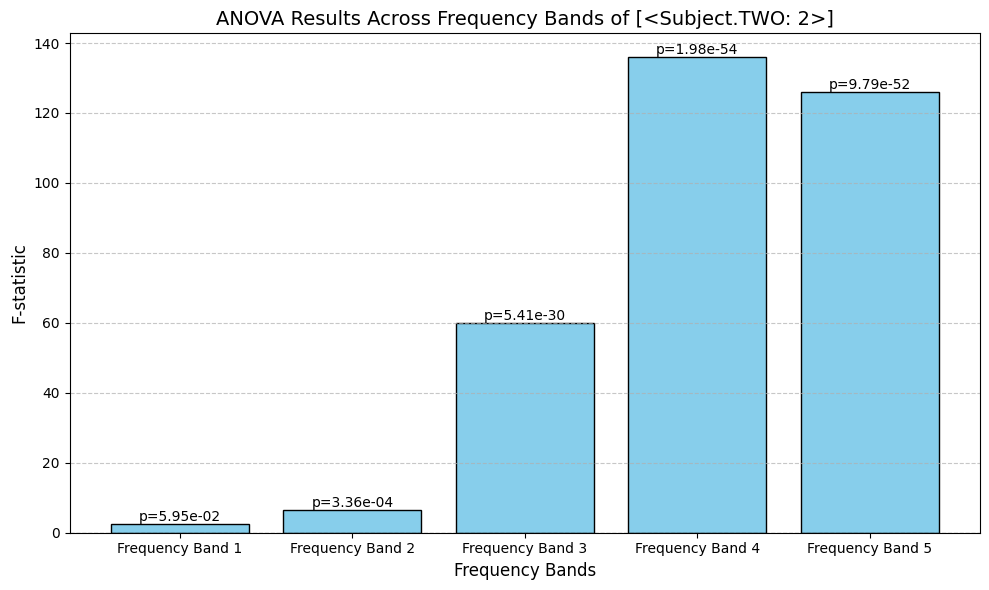

C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], pa

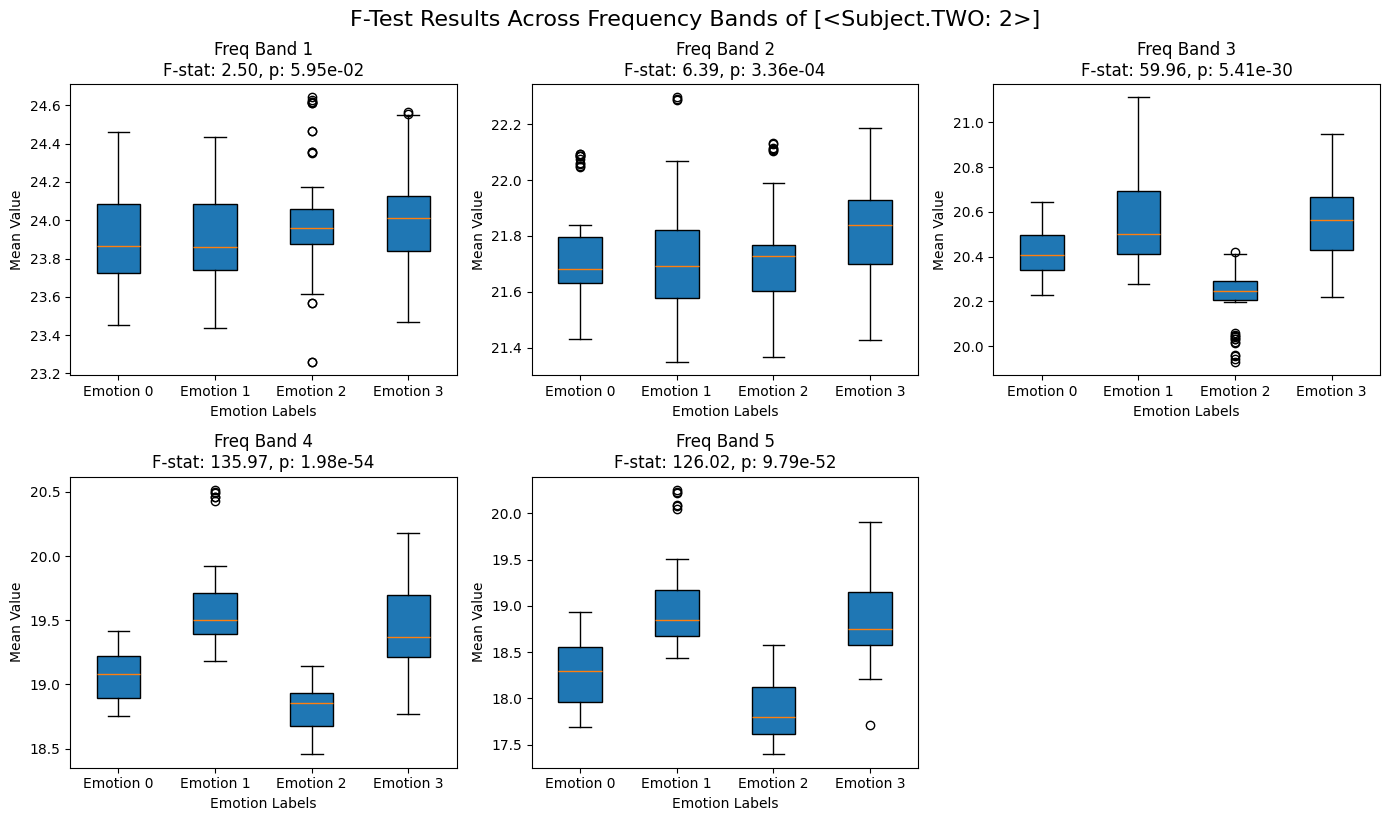

Frequency Band 1: F-statistic = 0.5455, p-value = 6.5158e-01
Frequency Band 2: F-statistic = 0.2669, p-value = 8.4927e-01
Frequency Band 3: F-statistic = 0.0366, p-value = 9.9060e-01
Frequency Band 4: F-statistic = 0.0417, p-value = 9.8864e-01
Frequency Band 5: F-statistic = 0.4517, p-value = 7.1632e-01


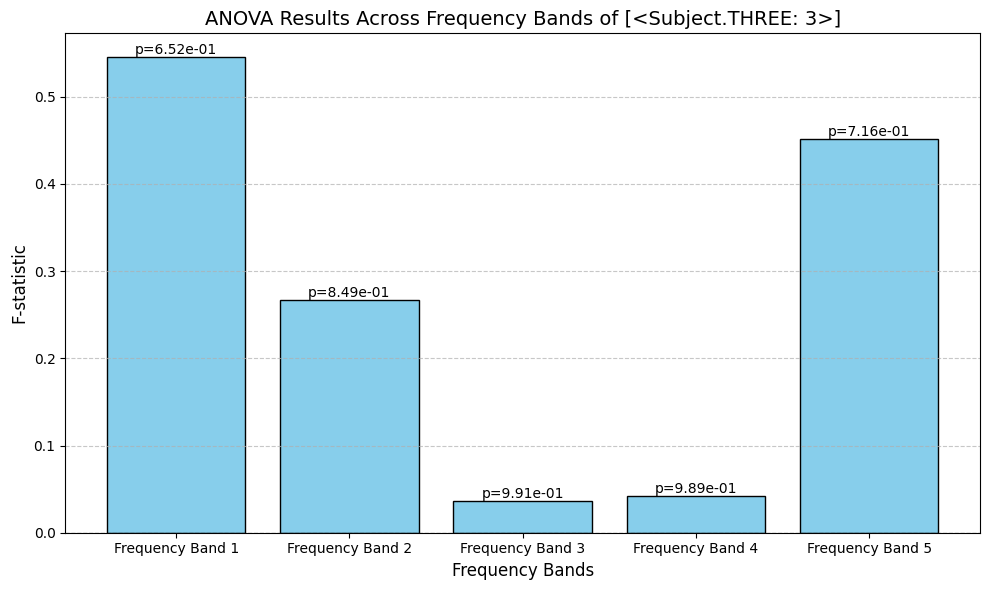

C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], pa

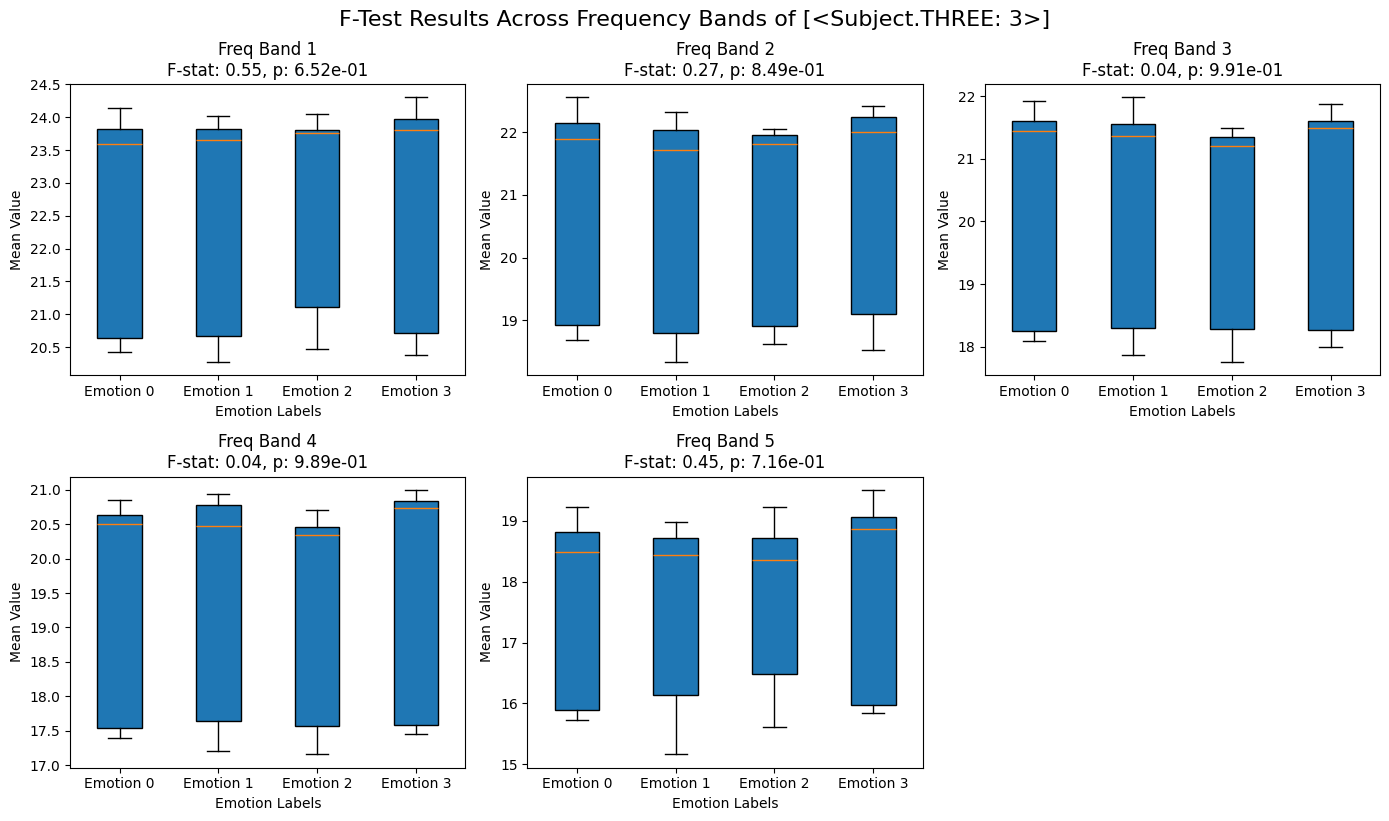

Frequency Band 1: F-statistic = 0.0383, p-value = 9.8998e-01
Frequency Band 2: F-statistic = 0.7525, p-value = 5.2169e-01
Frequency Band 3: F-statistic = 17.8489, p-value = 1.2431e-10
Frequency Band 4: F-statistic = 26.0965, p-value = 6.3866e-15
Frequency Band 5: F-statistic = 31.0969, p-value = 2.1760e-17


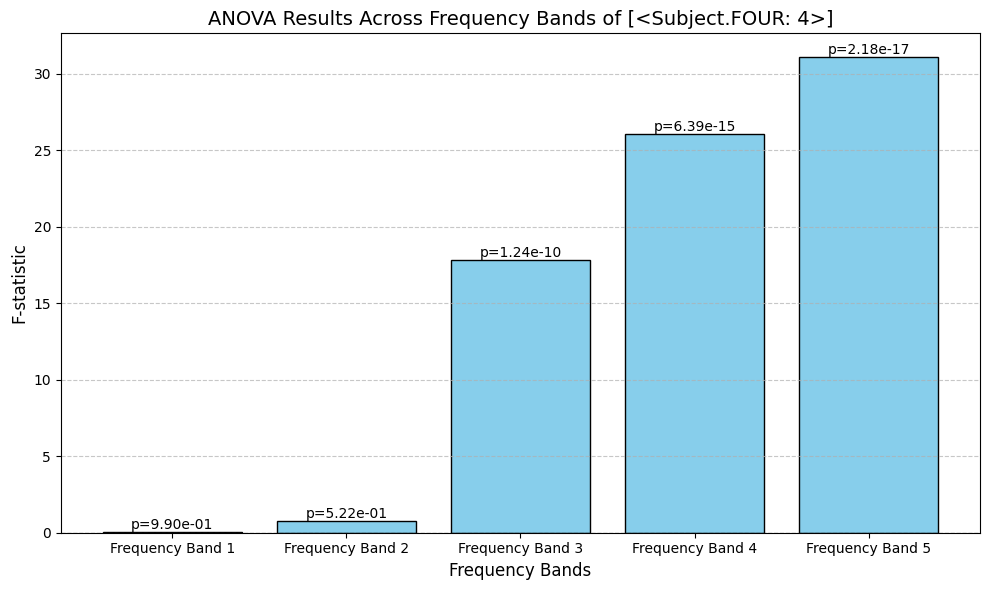

C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], pa

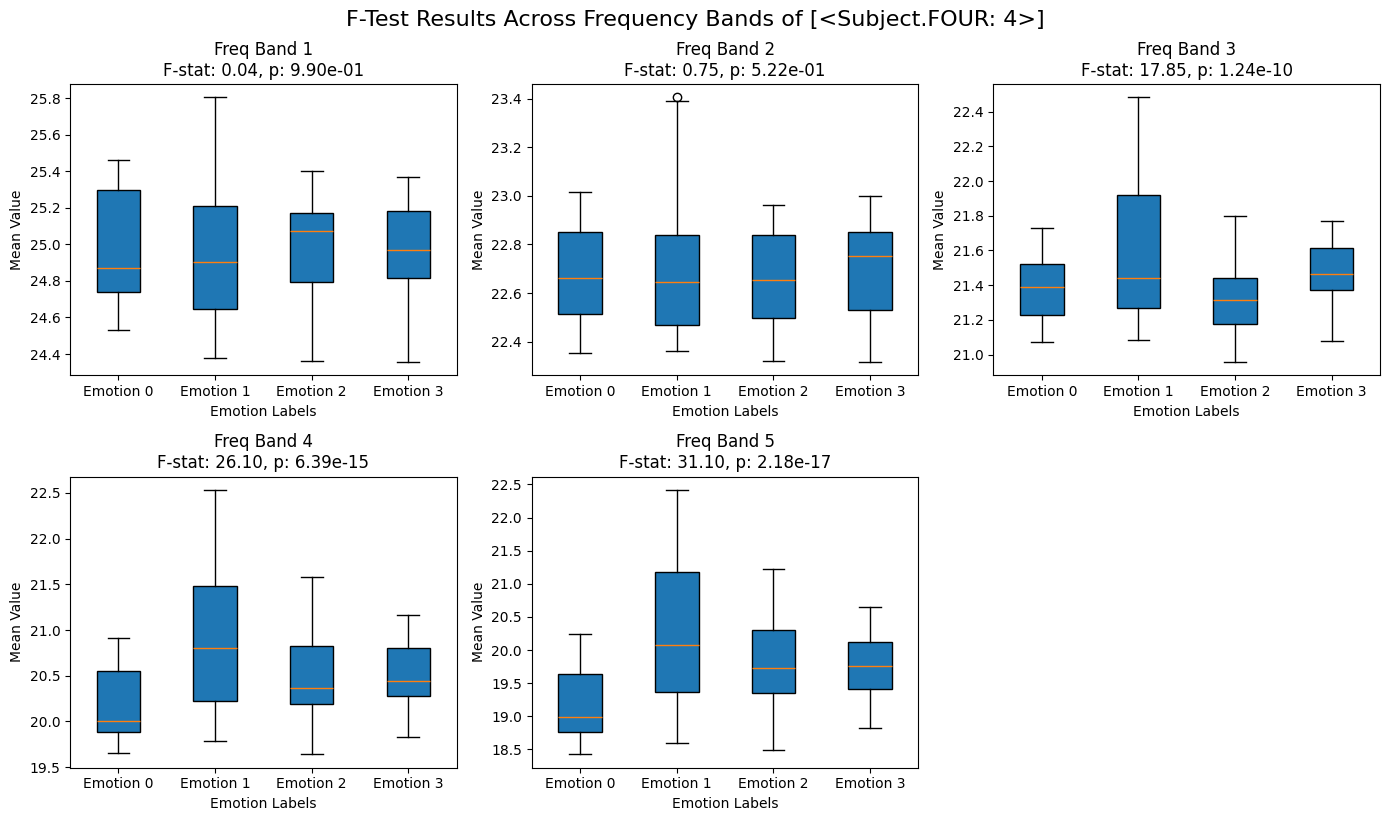

Frequency Band 1: F-statistic = 4.7004, p-value = 3.2156e-03
Frequency Band 2: F-statistic = 4.5927, p-value = 3.7146e-03
Frequency Band 3: F-statistic = 4.4811, p-value = 4.3135e-03
Frequency Band 4: F-statistic = 4.9880, p-value = 2.1873e-03
Frequency Band 5: F-statistic = 5.1659, p-value = 1.7232e-03


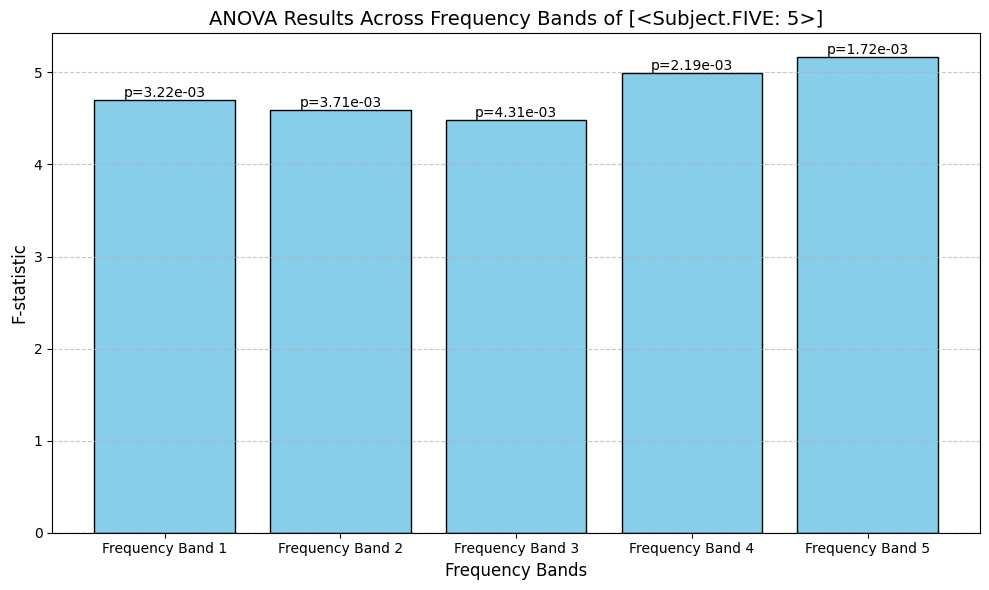

C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], pa

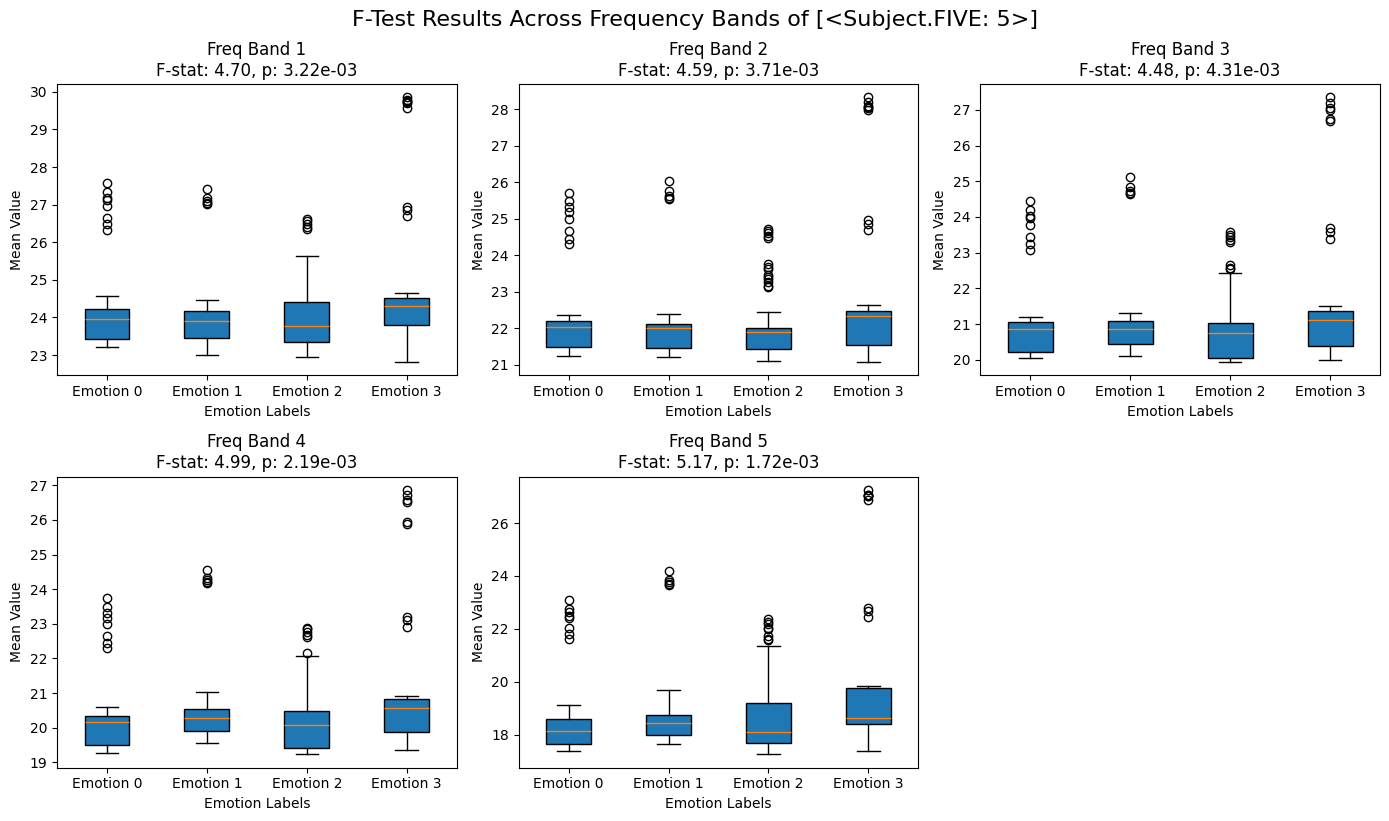

Frequency Band 1: F-statistic = 0.1323, p-value = 9.4081e-01
Frequency Band 2: F-statistic = 2.4025, p-value = 6.7890e-02
Frequency Band 3: F-statistic = 10.1112, p-value = 2.4009e-06
Frequency Band 4: F-statistic = 27.9873, p-value = 7.2591e-16
Frequency Band 5: F-statistic = 23.4716, p-value = 1.3801e-13


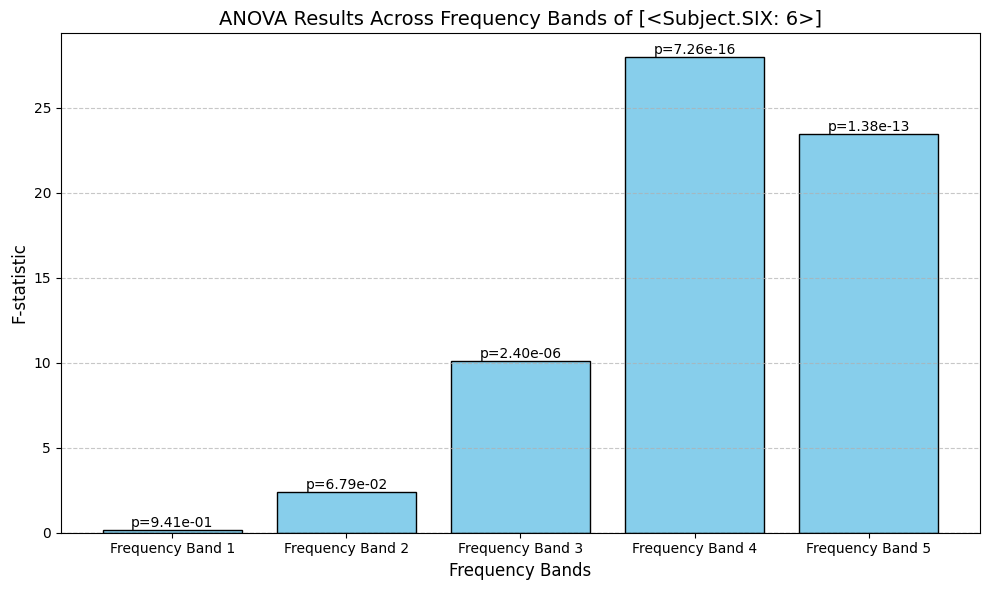

C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], pa

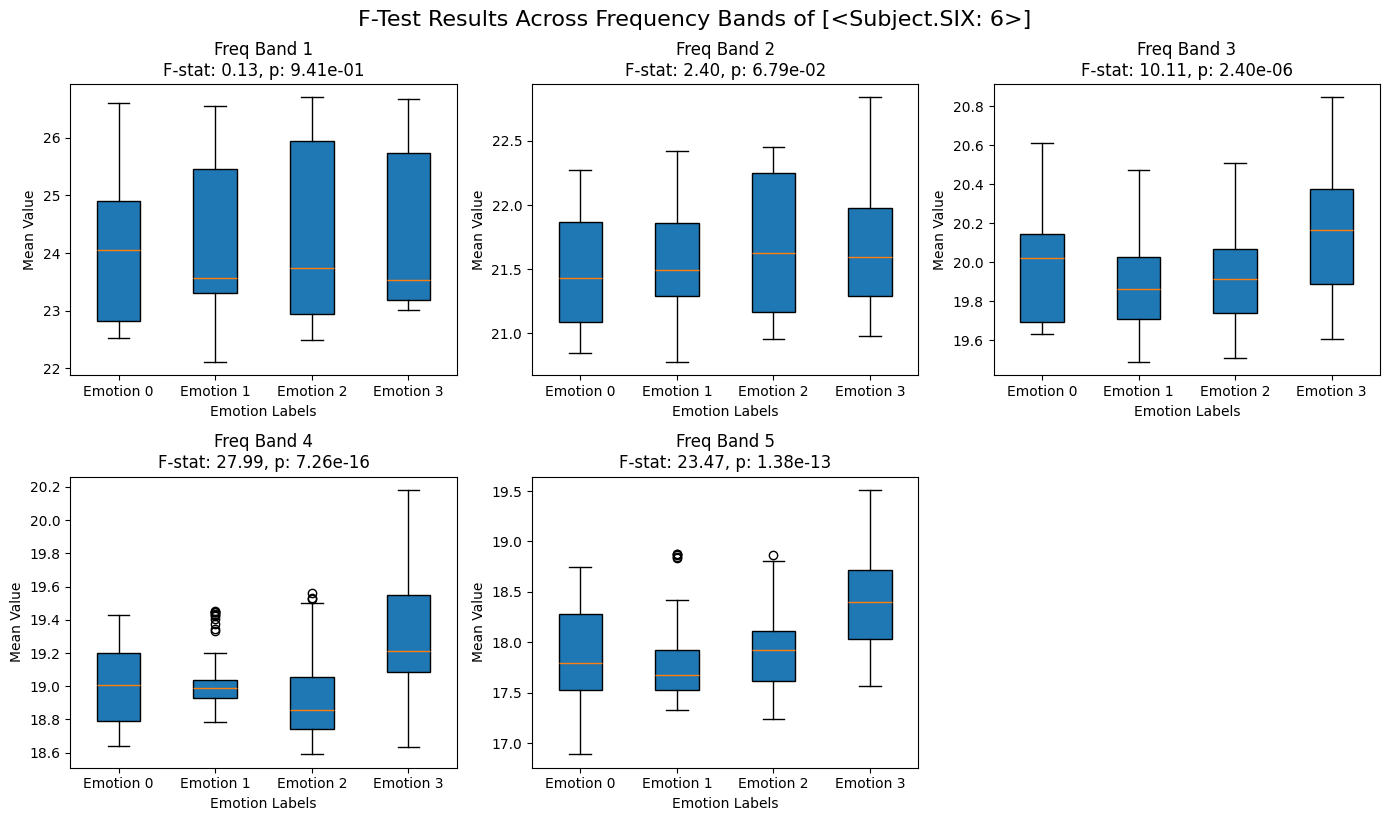

Frequency Band 1: F-statistic = 6.2112, p-value = 4.2474e-04
Frequency Band 2: F-statistic = 25.9454, p-value = 7.6095e-15
Frequency Band 3: F-statistic = 29.2973, p-value = 1.6395e-16
Frequency Band 4: F-statistic = 37.6688, p-value = 1.7181e-20
Frequency Band 5: F-statistic = 43.1340, p-value = 5.8533e-23


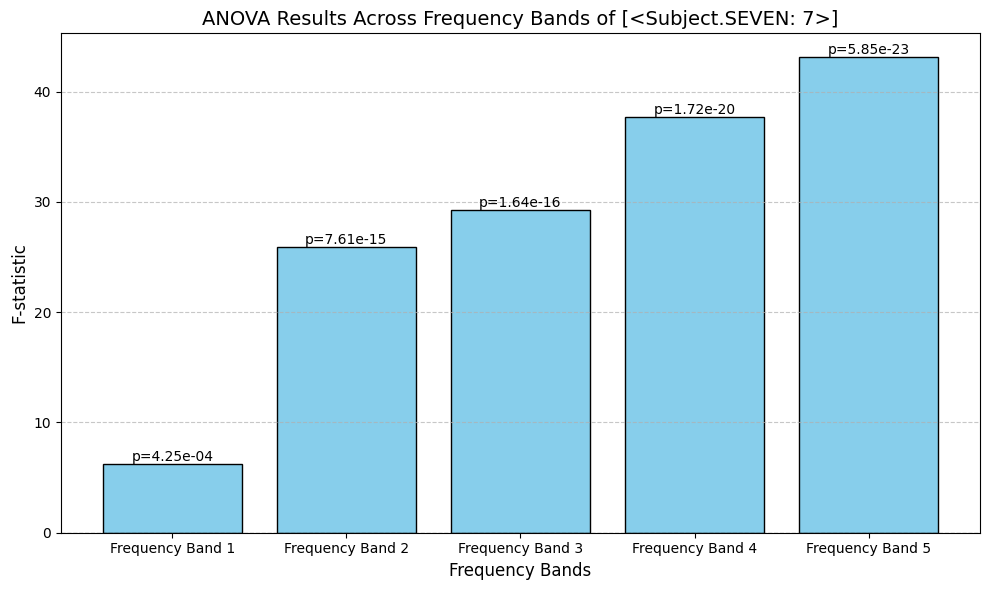

C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], pa

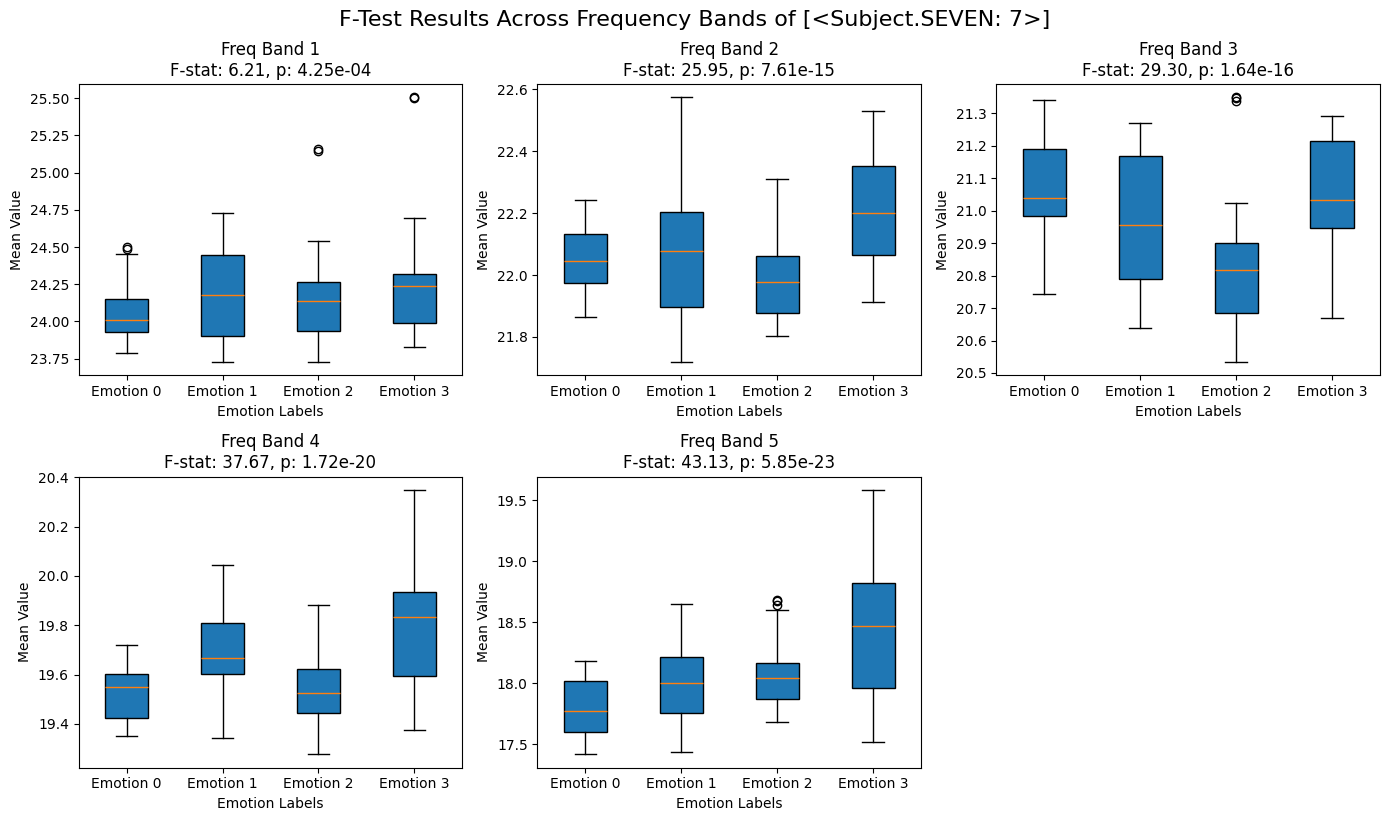

Frequency Band 1: F-statistic = 25.6779, p-value = 1.0381e-14
Frequency Band 2: F-statistic = 11.1073, p-value = 6.5254e-07
Frequency Band 3: F-statistic = 36.5865, p-value = 5.4395e-20
Frequency Band 4: F-statistic = 26.4644, p-value = 4.1728e-15
Frequency Band 5: F-statistic = 56.4292, p-value = 1.3978e-28


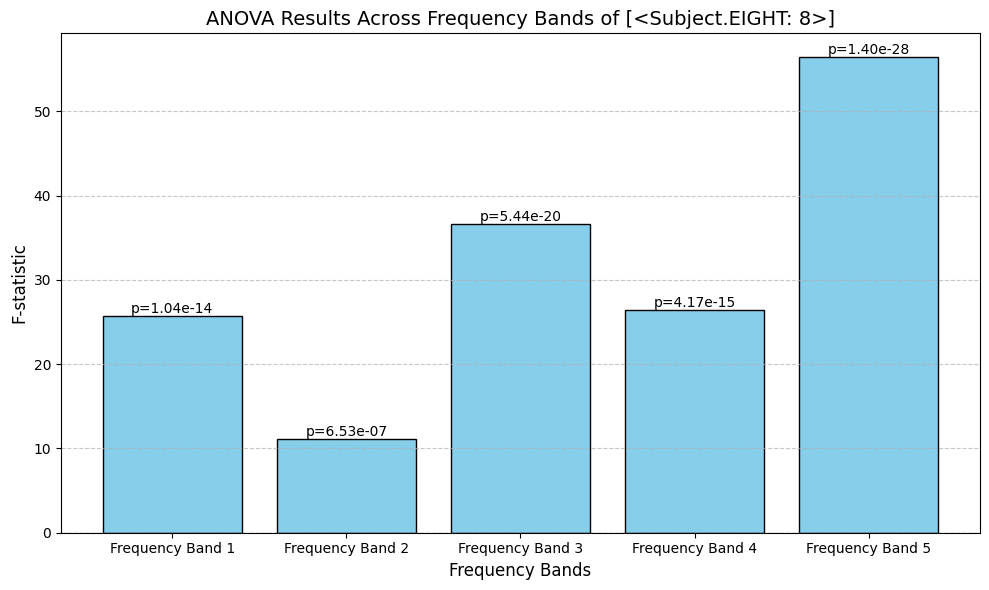

C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], pa

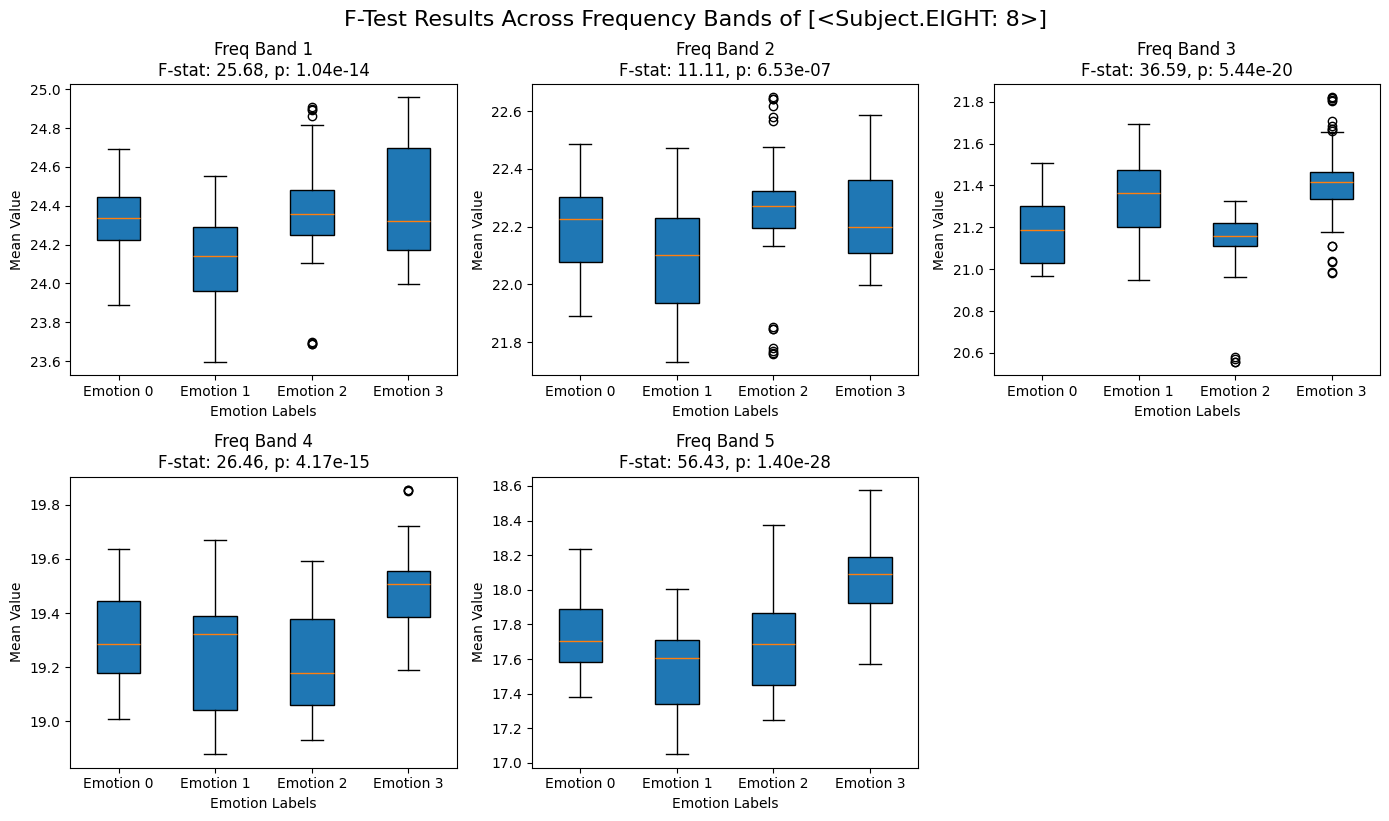

Frequency Band 1: F-statistic = 1.5220, p-value = 2.0898e-01
Frequency Band 2: F-statistic = 0.5790, p-value = 6.2927e-01
Frequency Band 3: F-statistic = 0.9819, p-value = 4.0165e-01
Frequency Band 4: F-statistic = 1.0146, p-value = 3.8659e-01
Frequency Band 5: F-statistic = 2.6329, p-value = 5.0249e-02


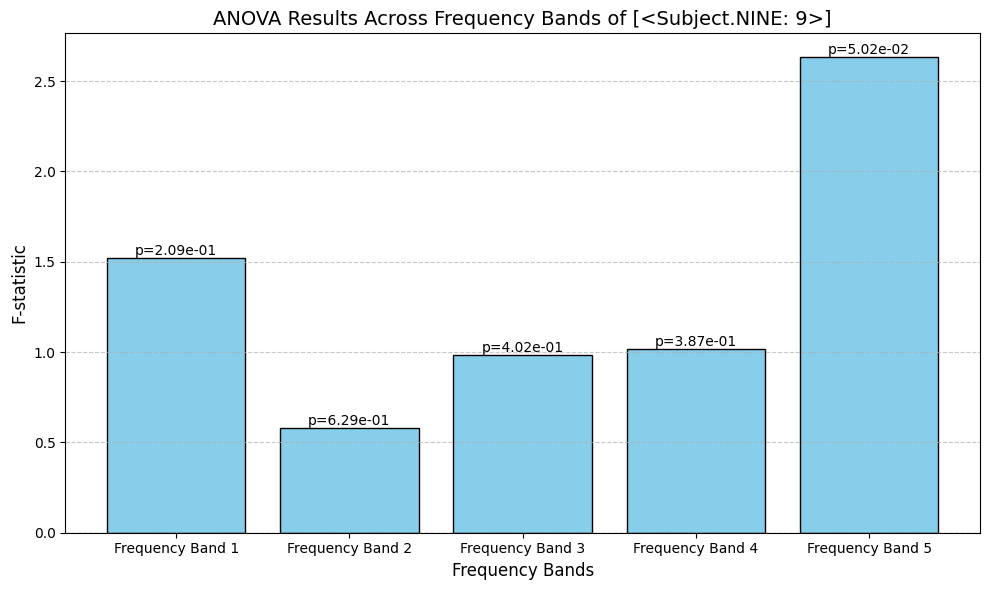

C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], pa

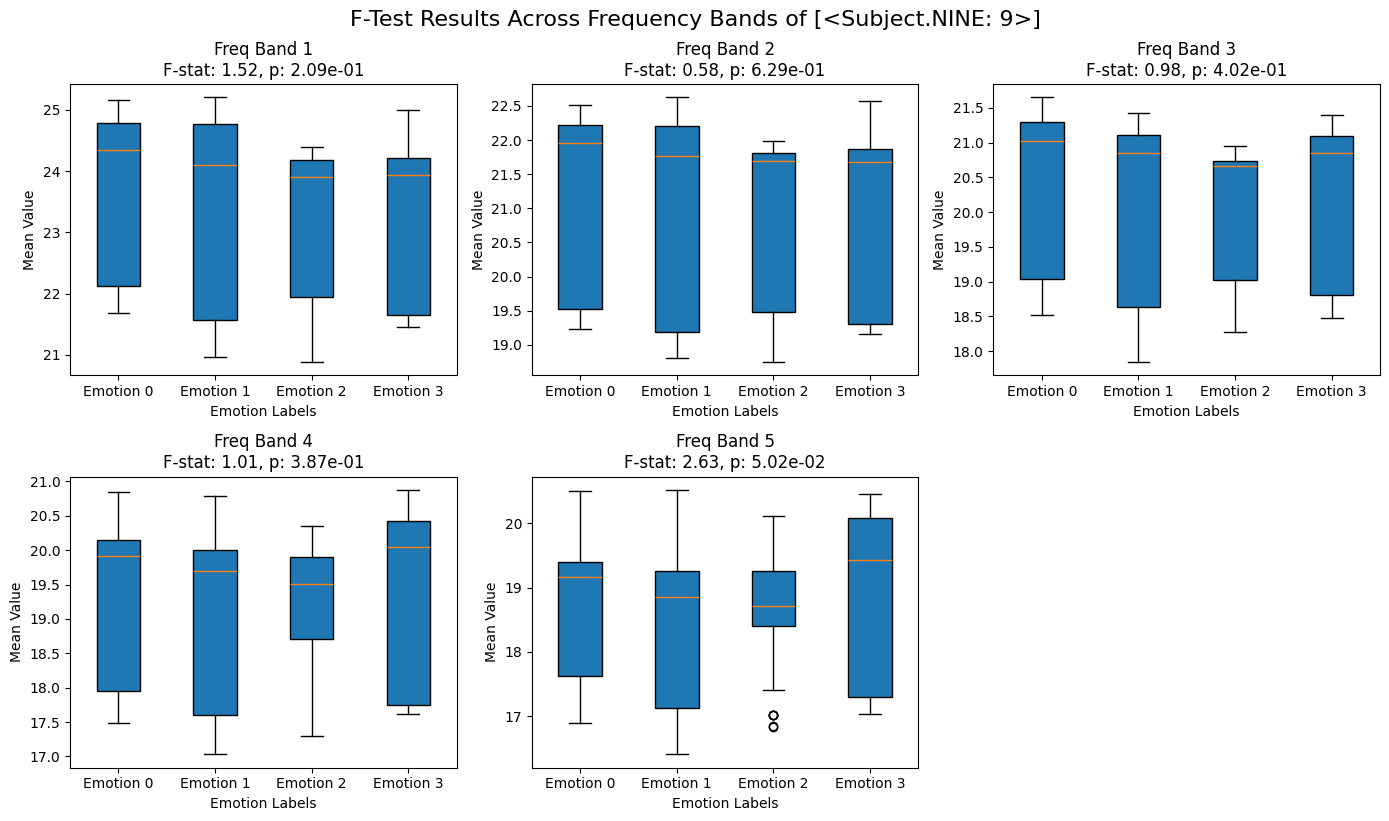

Frequency Band 1: F-statistic = 2.0058, p-value = 1.1336e-01
Frequency Band 2: F-statistic = 2.5164, p-value = 5.8519e-02
Frequency Band 3: F-statistic = 2.8474, p-value = 3.7913e-02
Frequency Band 4: F-statistic = 11.1075, p-value = 6.5245e-07
Frequency Band 5: F-statistic = 45.0102, p-value = 8.7578e-24


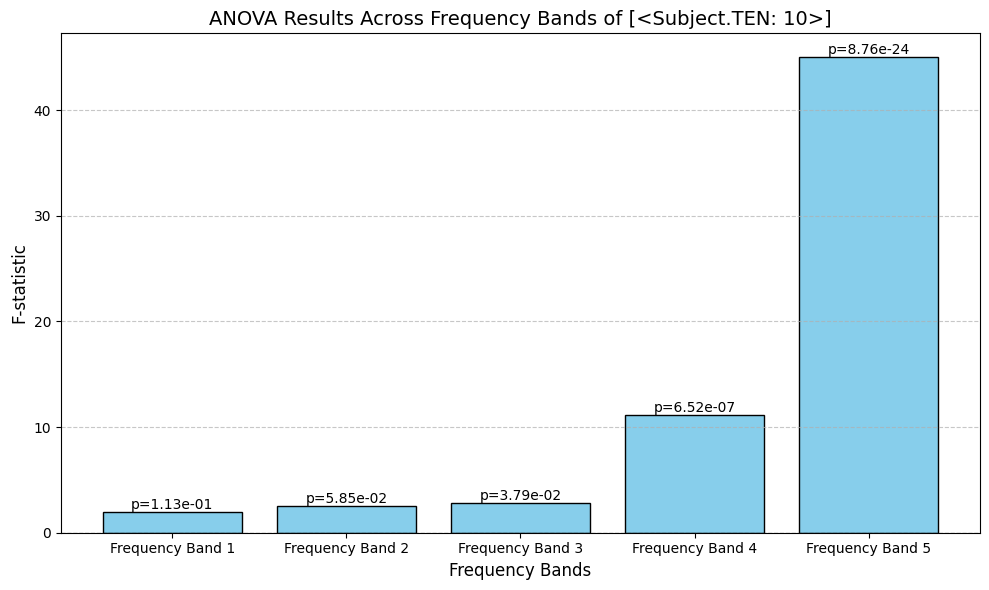

C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], pa

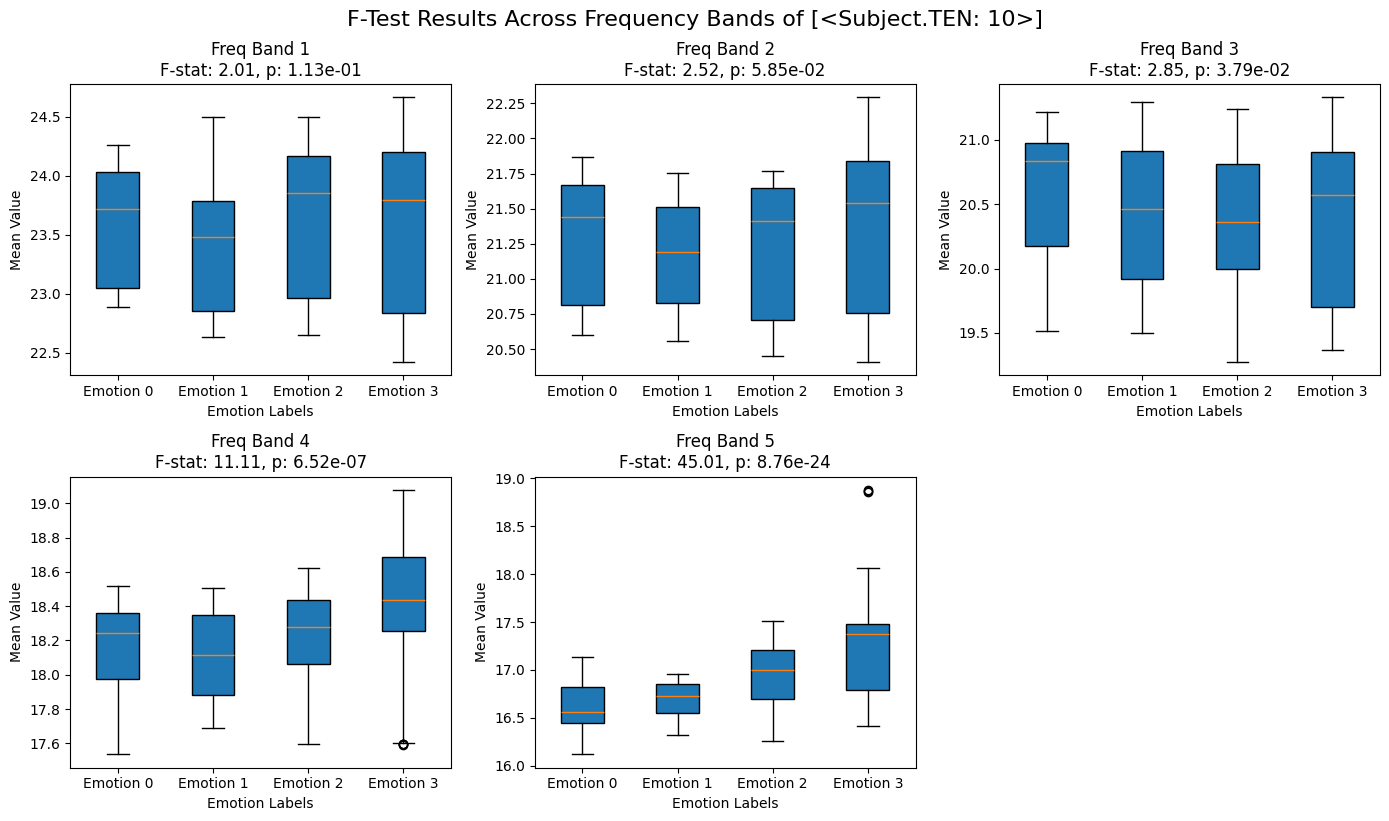

Frequency Band 1: F-statistic = 8.7233, p-value = 1.4956e-05
Frequency Band 2: F-statistic = 3.9039, p-value = 9.3317e-03
Frequency Band 3: F-statistic = 1.3259, p-value = 2.6615e-01
Frequency Band 4: F-statistic = 0.7100, p-value = 5.4673e-01
Frequency Band 5: F-statistic = 3.2490, p-value = 2.2305e-02


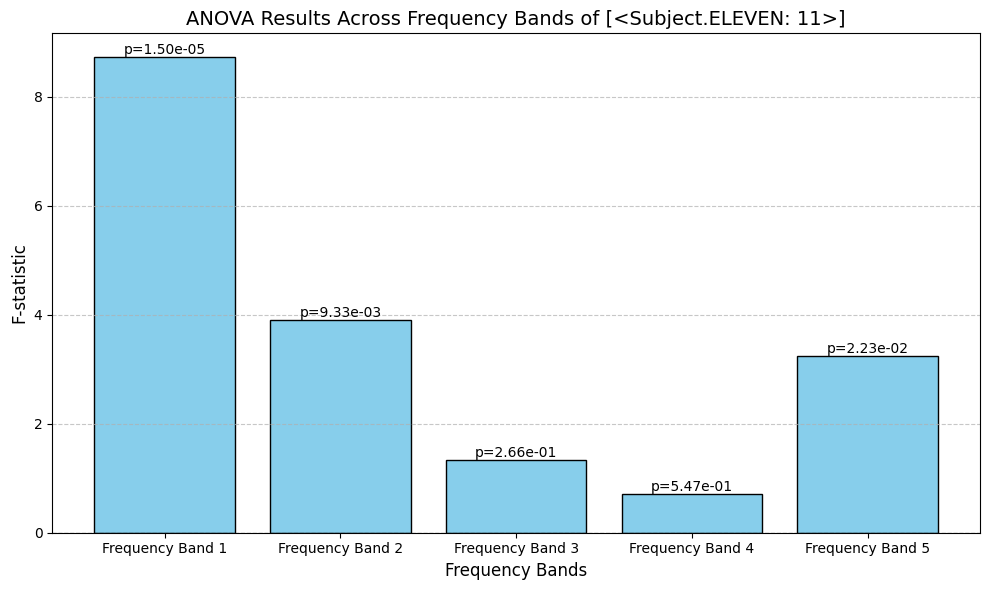

C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], pa

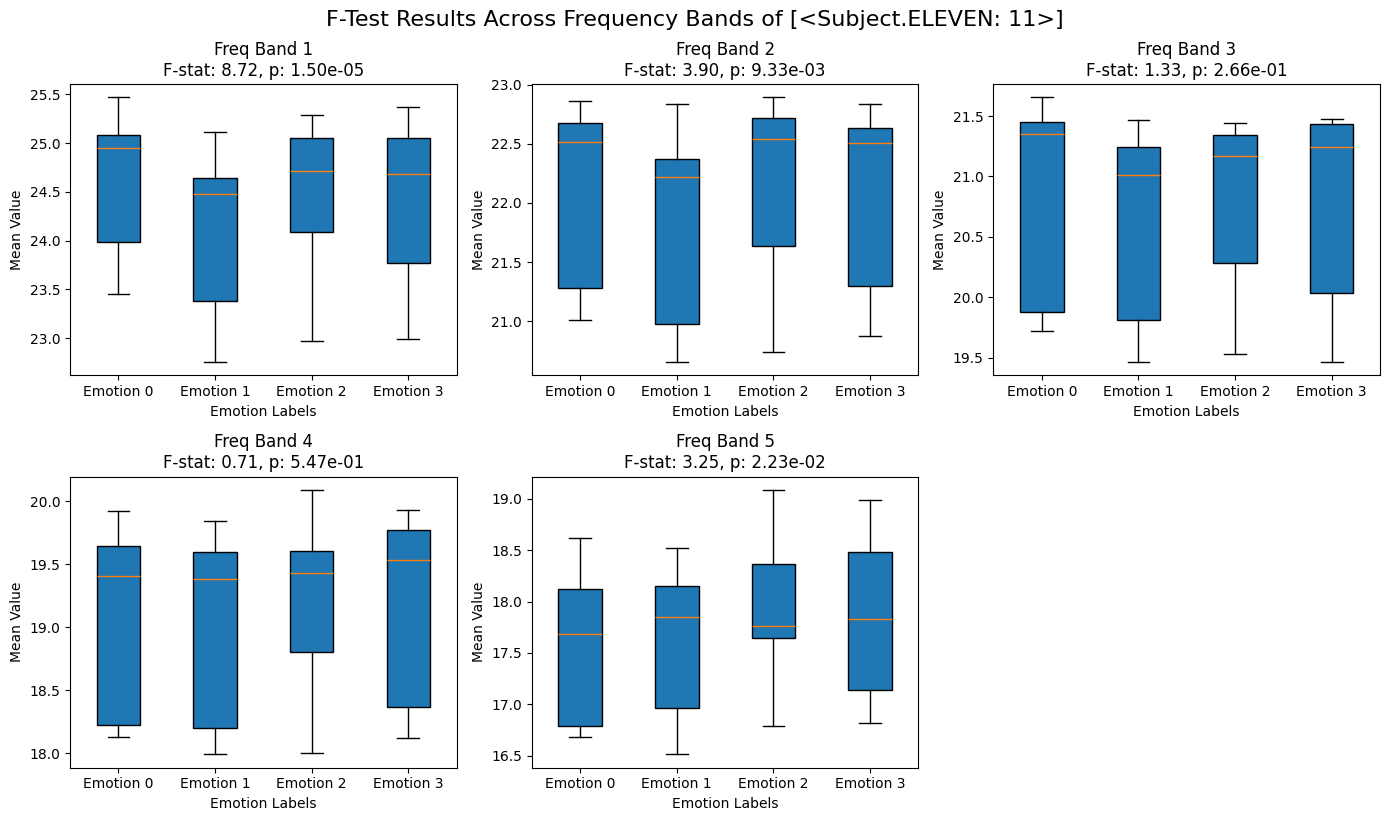

Frequency Band 1: F-statistic = 7.6509, p-value = 6.2107e-05
Frequency Band 2: F-statistic = 11.5207, p-value = 3.8105e-07
Frequency Band 3: F-statistic = 5.8341, p-value = 7.0381e-04
Frequency Band 4: F-statistic = 2.4286, p-value = 6.5623e-02
Frequency Band 5: F-statistic = 3.7222, p-value = 1.1890e-02


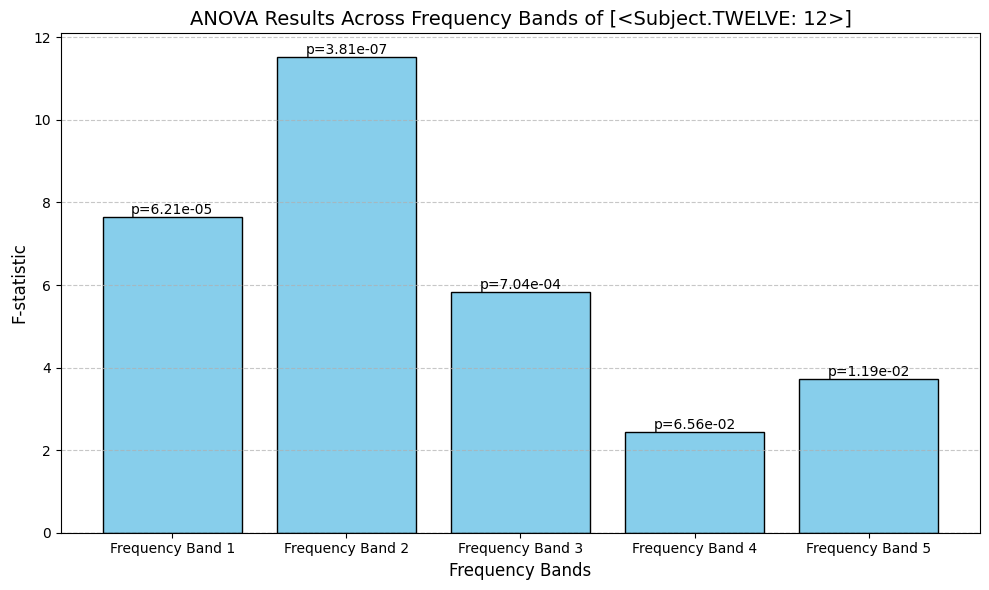

C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], pa

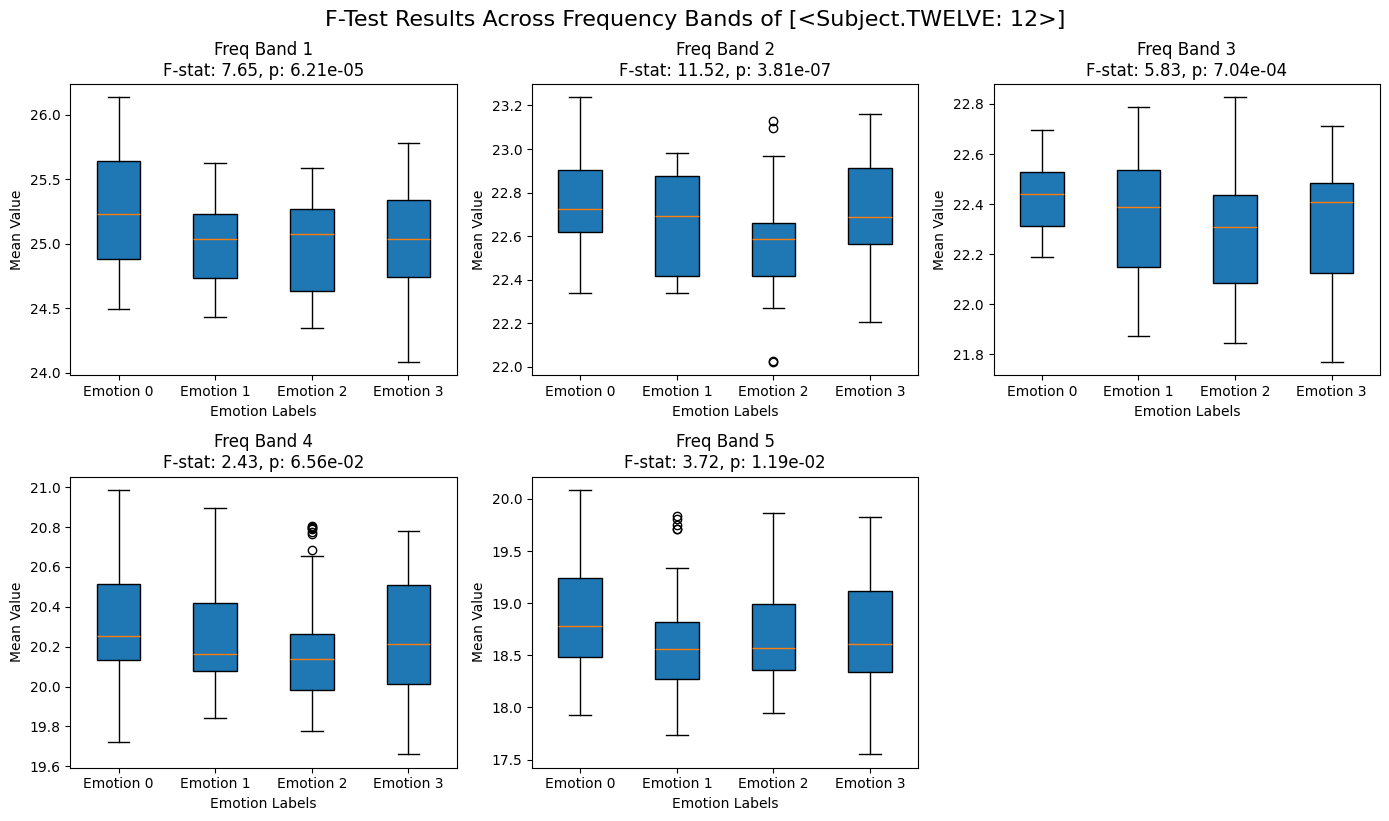

Frequency Band 1: F-statistic = 23.2543, p-value = 1.7849e-13
Frequency Band 2: F-statistic = 34.4059, p-value = 5.7051e-19
Frequency Band 3: F-statistic = 17.1558, p-value = 2.9374e-10
Frequency Band 4: F-statistic = 0.3646, p-value = 7.7864e-01
Frequency Band 5: F-statistic = 1.1441, p-value = 3.3162e-01


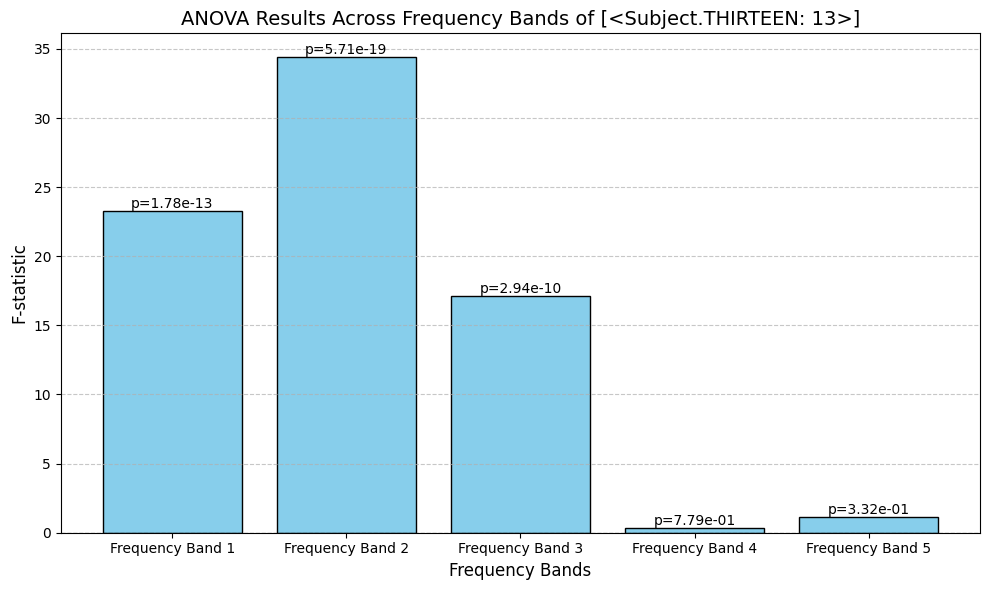

C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], pa

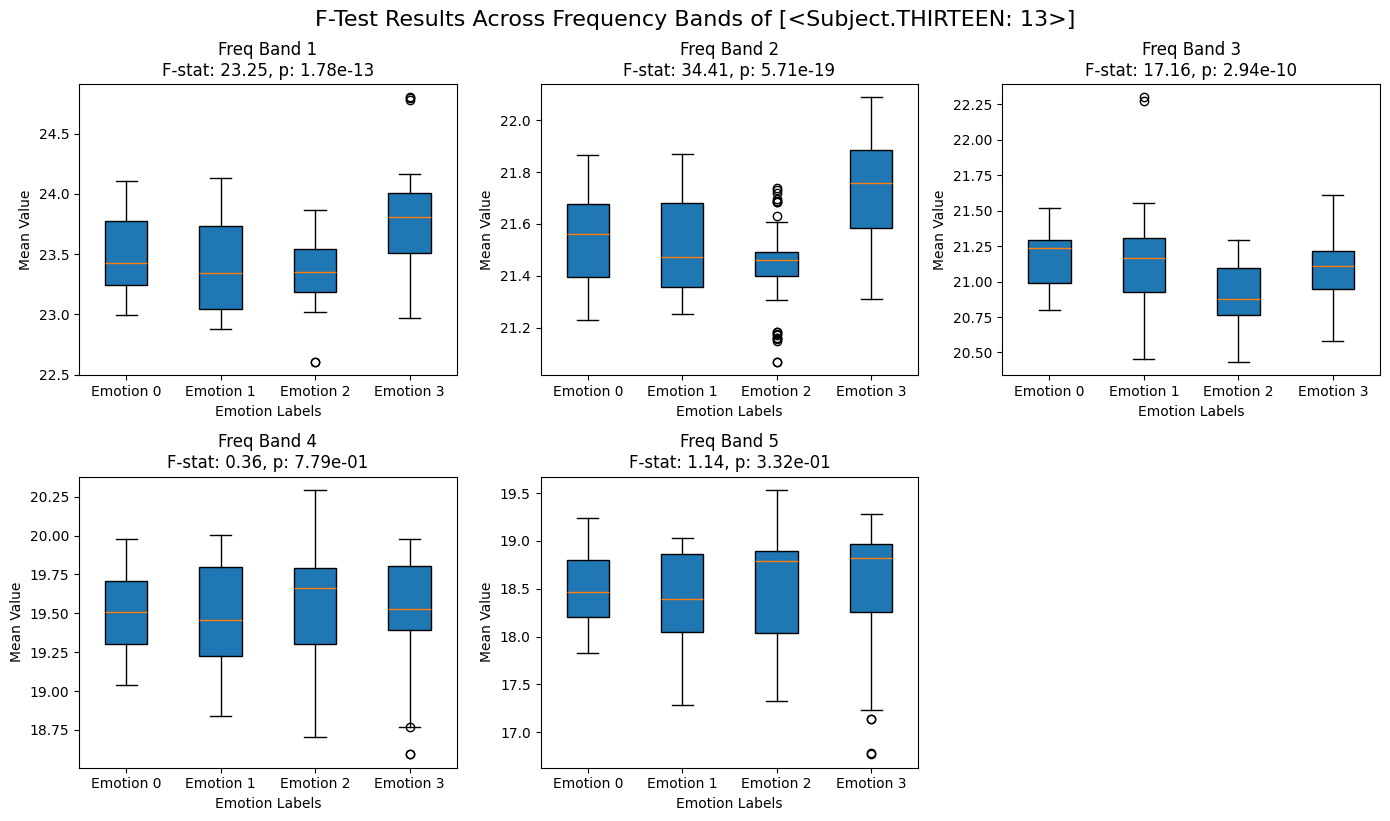

Frequency Band 1: F-statistic = 10.2204, p-value = 2.0805e-06
Frequency Band 2: F-statistic = 29.7229, p-value = 1.0144e-16
Frequency Band 3: F-statistic = 18.2083, p-value = 7.9736e-11
Frequency Band 4: F-statistic = 5.9429, p-value = 6.0833e-04
Frequency Band 5: F-statistic = 4.7543, p-value = 2.9918e-03


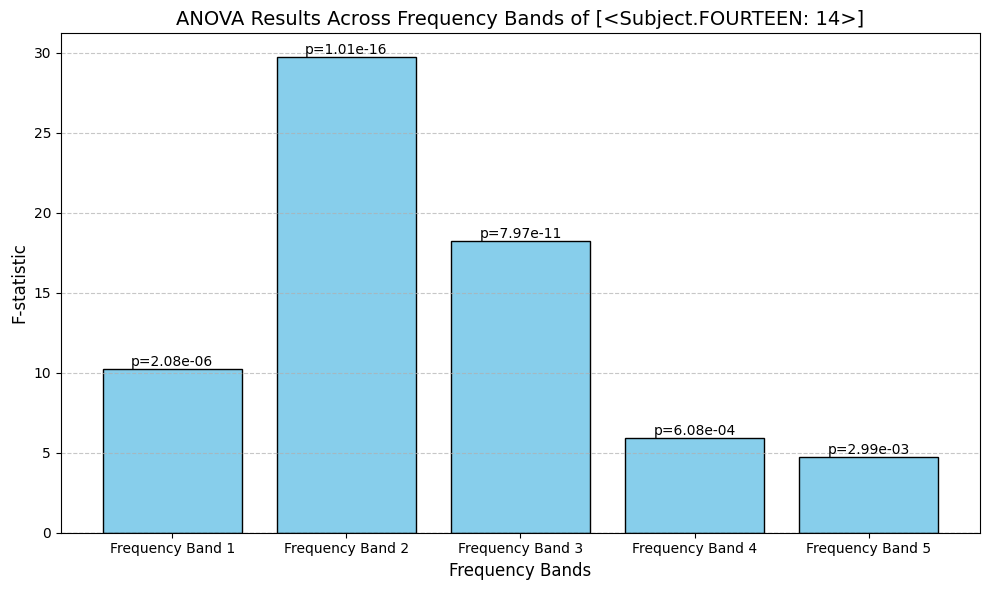

C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], pa

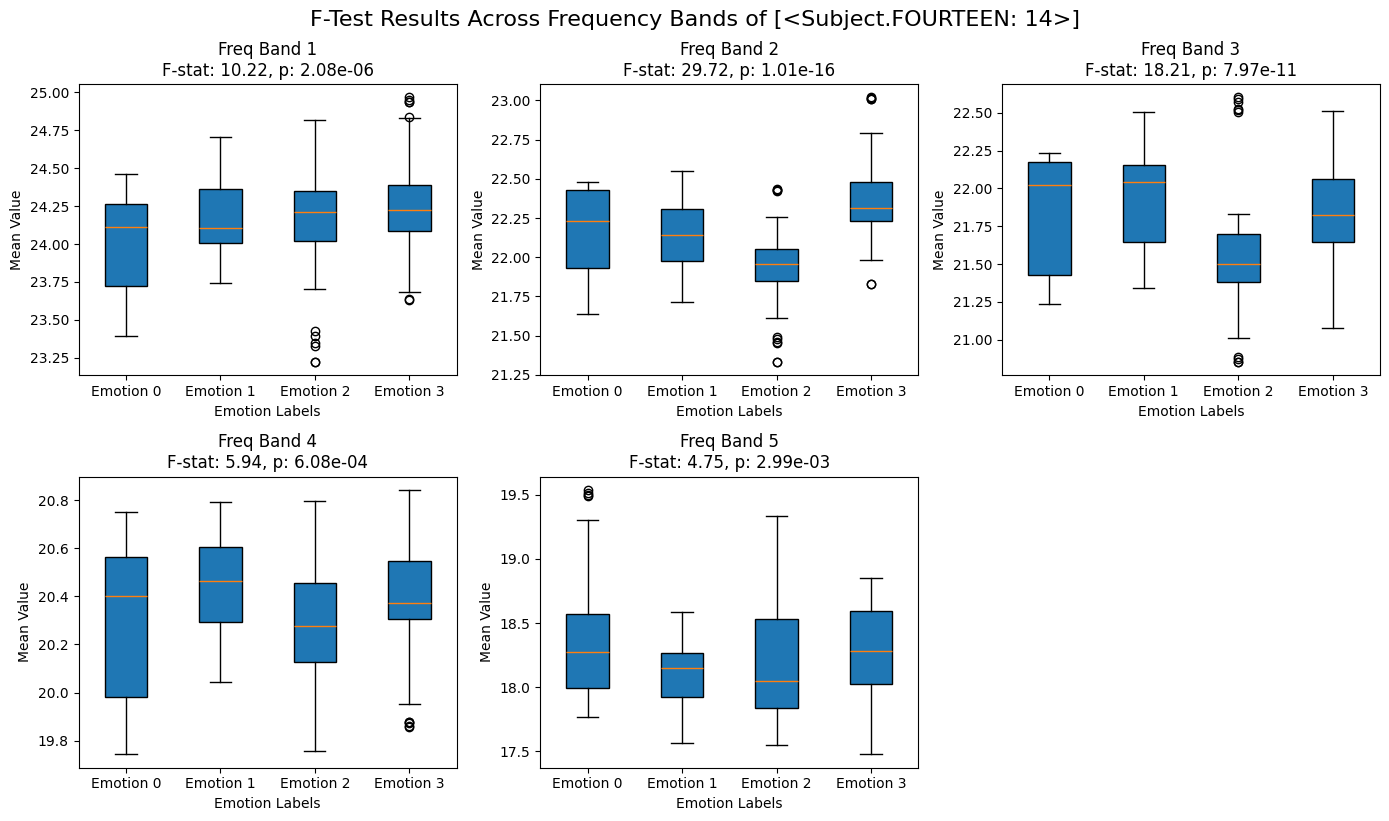

Frequency Band 1: F-statistic = 36.9409, p-value = 3.7256e-20
Frequency Band 2: F-statistic = 42.1364, p-value = 1.6240e-22
Frequency Band 3: F-statistic = 29.5723, p-value = 1.2020e-16
Frequency Band 4: F-statistic = 15.4406, p-value = 2.5184e-09
Frequency Band 5: F-statistic = 11.7078, p-value = 2.9888e-07


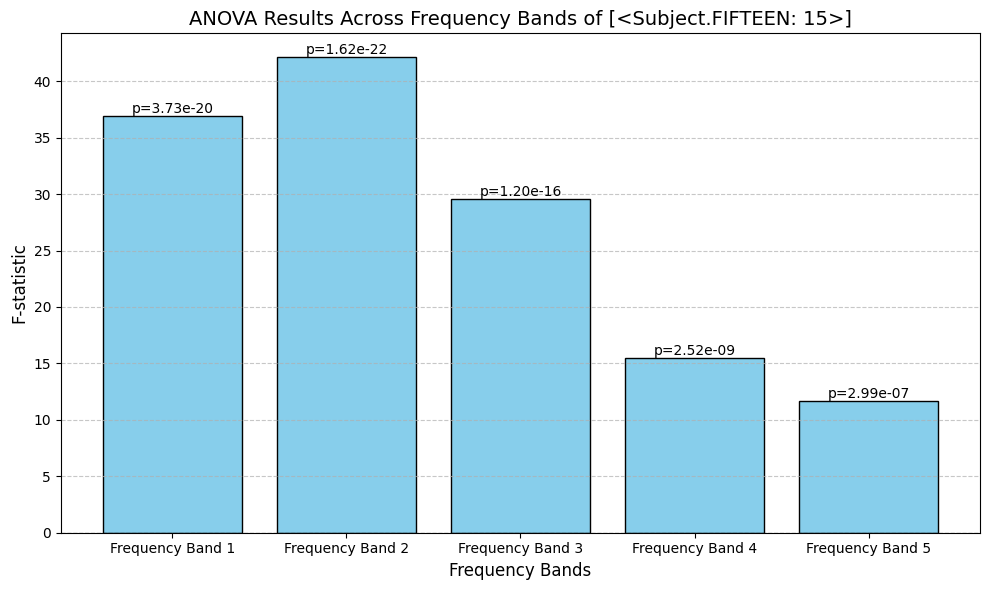

C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
C:\Users\Han\AppData\Local\Temp\ipykernel_7860\1332176991.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], pa

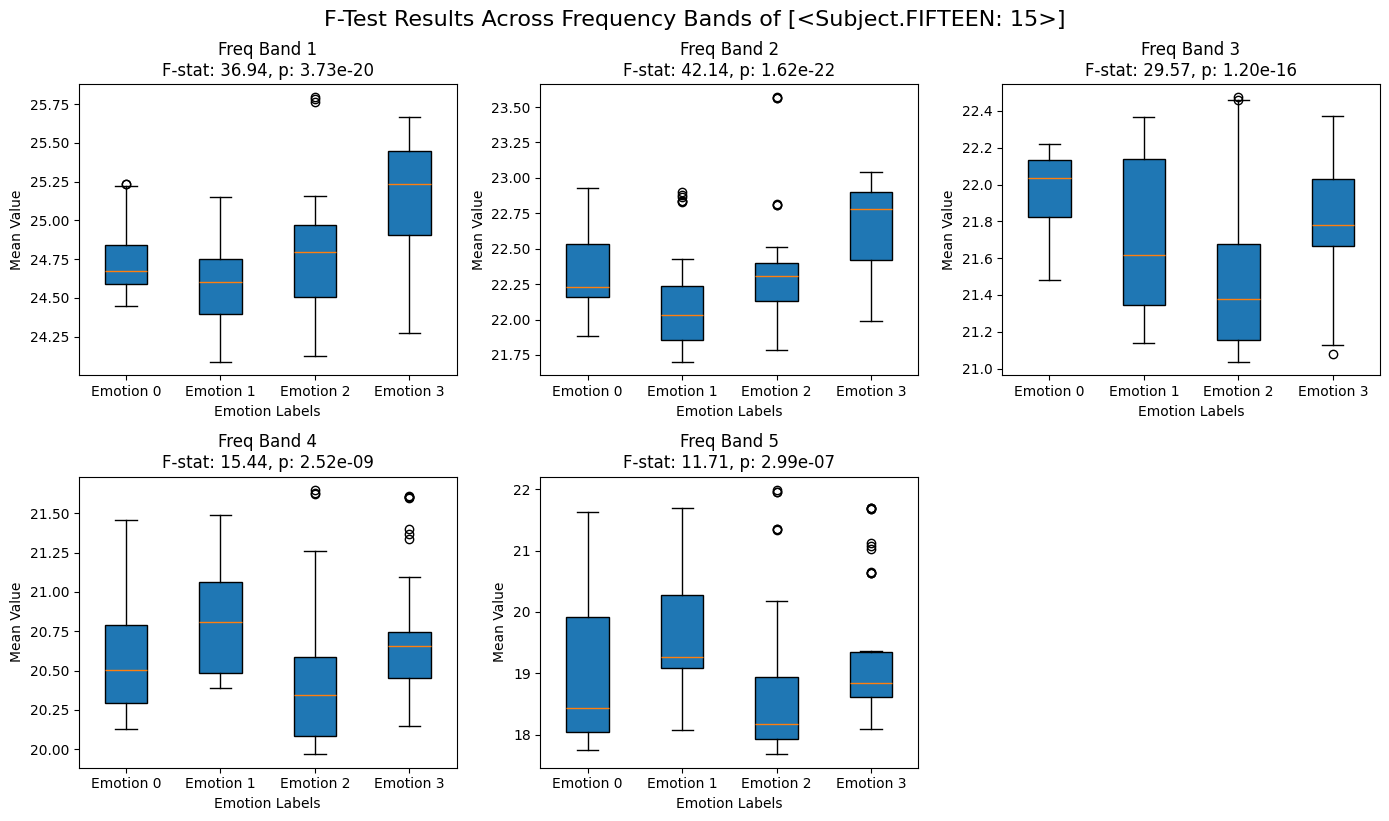

In [44]:
import pre.conformer 
for subj in Subject:
    sub_list = [subj]

    data_sub1_feat, label_sub1 = pre.conformer.get_feature_dataset(eeg_feature_data_path, 
                                                                sub_list, 
                                                                sessions = [Session.ONE, Session.TWO, Session.THREE], 
                                                                trails=list(range(0, 24)), 
                                                                method= FeatureMethod.DE_LDS, 
                                                                sample_length=10)
    from scipy.stats import f_oneway
    # Step 1: Average data over time samples and channels
    # Shape after mean: (570, 5) - 570 chunks, 5 frequency bands
    data_mean = data_sub1_feat.mean(axis=(1, 2))
    # Step 2: Separate data into groups by emotion labels
    emotion_groups = [data_mean[label_sub1 == i] for i in range(4)]

    # Step 3: Perform ANOVA (F-test) for each frequency band
    results = {}
    for band in range(5):  # Loop over frequency bands
        # Extract data for this frequency band across all emotion groups
        band_data = [group[:, band] for group in emotion_groups]
        # Perform one-way ANOVA
        f_stat, p_value = f_oneway(*band_data)
        results[f"Frequency Band {band + 1}"] = {"F-statistic": f_stat, "p-value": p_value}

    # Step 4: Display results
    for band, stats in results.items():
        print(f"{band}: F-statistic = {stats['F-statistic']:.4f}, p-value = {stats['p-value']:.4e}")

    import matplotlib.pyplot as plt

    # Step 5: Extract results for visualization
    bands = list(results.keys())
    f_stats = [stats["F-statistic"] for stats in results.values()]
    p_values = [stats["p-value"] for stats in results.values()]

    # Step 6: Create the bar plot for F-statistics
    plt.figure(figsize=(10, 6))
    bars = plt.bar(bands, f_stats, color='skyblue', edgecolor='black')

    # Annotate the bars with p-values
    for bar, p_value in zip(bars, p_values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                f"p={p_value:.2e}", ha='center', va='bottom', fontsize=10)

    # Add labels, title, and grid
    plt.xlabel("Frequency Bands", fontsize=12)
    plt.ylabel("F-statistic", fontsize=12)
    plt.title(f"ANOVA Results Across Frequency Bands of {sub_list}", fontsize=14)
    plt.axhline(y=0, color='black', linewidth=0.8, linestyle='--')  # Reference line
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Step 1: Average over time samples and channels
    data_mean = data_sub1_feat.mean(axis=(1, 2))  # Shape: (570, 5)

    # Step 2: Group data by emotion labels
    emotion_groups = [data_mean[label_sub1 == i] for i in range(4)]

    # Step 3: Perform F-test for each frequency band
    results = {}
    for band in range(5):  # Loop over frequency bands
        # Extract data for this frequency band across all emotion groups
        band_data = [group[:, band] for group in emotion_groups]
        # Perform one-way ANOVA
        f_stat, p_value = f_oneway(*band_data)
        results[f"Frequency Band {band + 1}"] = {"F-statistic": f_stat, "p-value": p_value}

    # Step 4: Visualize results for each band
    plt.figure(figsize=(14, 8))
    for band in range(5):
        # Extract data for this band
        band_data = [group[:, band] for group in emotion_groups]
        
        # Create subplot for each band
        plt.subplot(2, 3, band + 1)
        plt.boxplot(band_data, labels=["Emotion 0", "Emotion 1", "Emotion 2", "Emotion 3"], patch_artist=True)
        
        # Add F-statistic and p-value as the title
        f_stat = results[f"Frequency Band {band + 1}"]["F-statistic"]
        p_value = results[f"Frequency Band {band + 1}"]["p-value"]
        plt.title(f"Freq Band {band + 1}\nF-stat: {f_stat:.2f}, p: {p_value:.2e}")
        
        # Add labels
        plt.xlabel("Emotion Labels")
        plt.ylabel("Mean Value")

    # Adjust layout and show plot
    plt.tight_layout()
    plt.suptitle(f"F-Test Results Across Frequency Bands of {sub_list}", fontsize=16, y=1.02)
    plt.show()


Correlation Plot

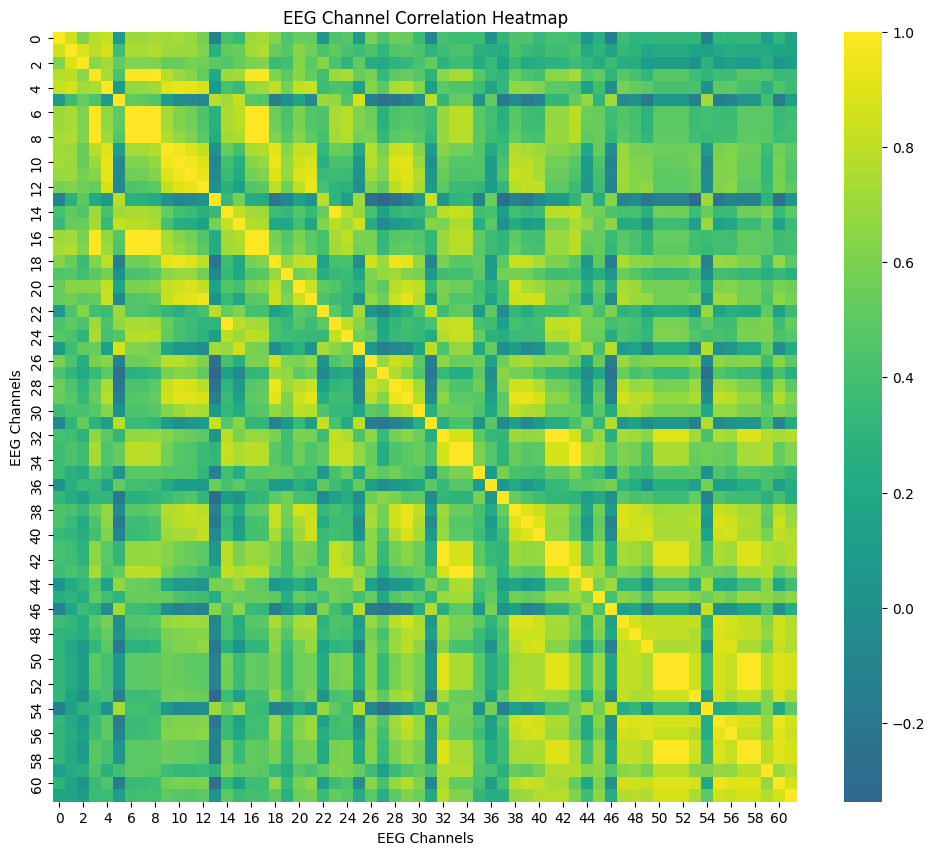

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your EEG data is stored in a 2D NumPy array called 'eeg_data'
# with shape (62, 30000) representing 62 channels and 30000 time samples

# Convert the EEG data to a Pandas DataFrame
eeg_df = pd.DataFrame(data[1].T)  # Transpose to have channels as columns

# Calculate the correlation matrix
correlation_matrix = eeg_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=False, cmap='viridis', center=0)
plt.title('EEG Channel Correlation Heatmap')
plt.xlabel('EEG Channels')
plt.ylabel('EEG Channels')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have 'eeg_data' (62, 30000) and 'emotion_labels' (30000)

# Choose a specific channel to compare (e.g., channel 1)
channel_to_compare = 0

# Create a DataFrame for plotting
data = {'Amplitude': eeg_data[channel_to_compare, :], 'Emotion': emotion_labels}
df = pd.DataFrame(data)

# Plot box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Emotion', y='Amplitude', data=df)
plt.title(f'EEG Amplitude Distribution for Channel {channel_to_compare + 1}')
plt.show()

Exploratory data analysis

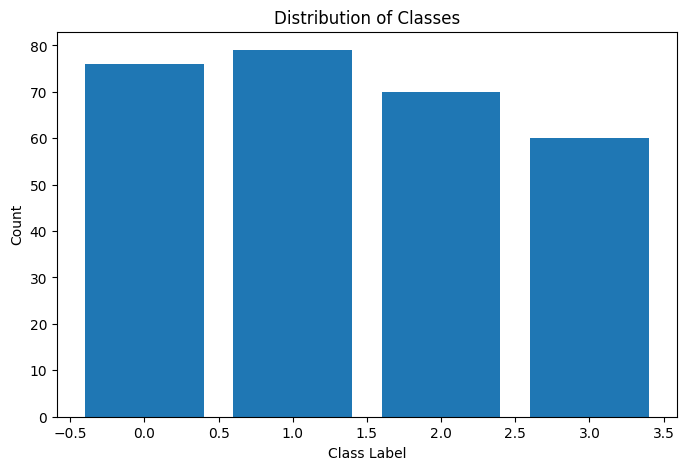

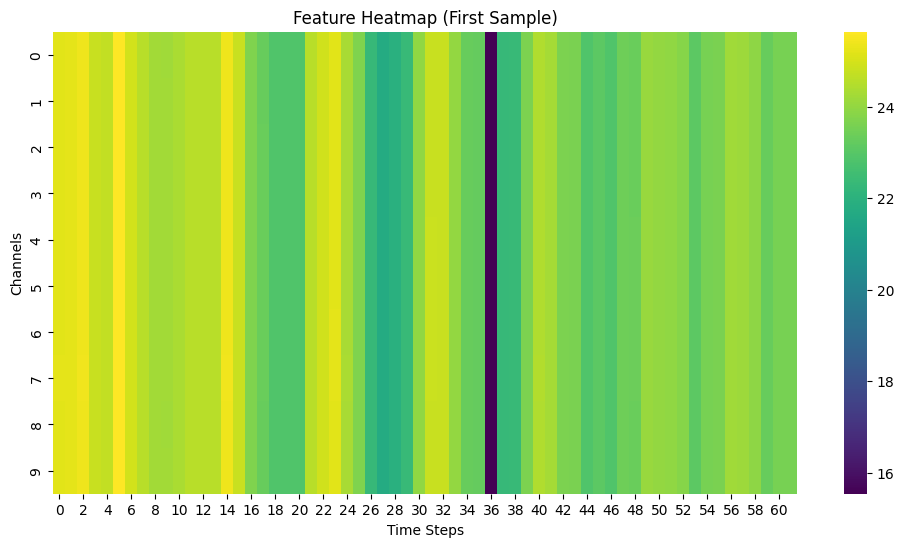

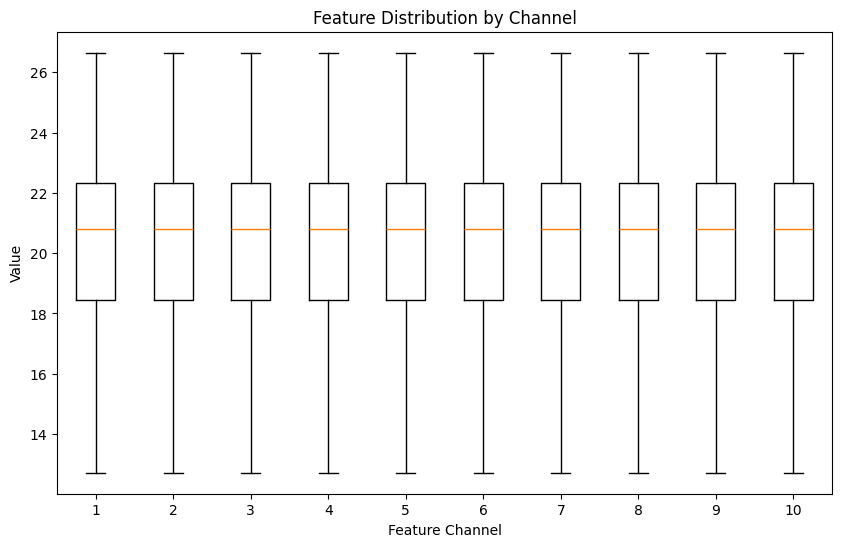

X shape: (285, 5, 10, 62)
Y shape: (285,)


In [ ]:
import seaborn as sns

# 1. Visualize class distribution
plt.figure(figsize=(8, 5))
unique_labels, counts = np.unique(y, return_counts=True)
plt.bar(unique_labels, counts)
plt.title('Distribution of Classes')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

# 2. Visualize feature patterns
# Plot first sample's features across channels and time
plt.figure(figsize=(12, 6))
sns.heatmap(x[0, 0], cmap='viridis')
plt.title('Feature Heatmap (First Sample)')
plt.xlabel('Time Steps')
plt.ylabel('Channels')
plt.show()

# 3. Feature distribution across all samples
plt.figure(figsize=(10, 6))
plt.boxplot([x[:, :, i].flatten() for i in range(x.shape[2])])
plt.title('Feature Distribution by Channel')
plt.xlabel('Feature Channel')
plt.ylabel('Value')
plt.show()

# Print shape information
print(f"X shape: {x.shape}")  # Should be (n_samples, n_channels, n_features)
print(f"Y shape: {y.shape}")  # Should be (n_samples,)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Original shape: (285, 5, 10, 62)
# 285: time samples/block_size
# 5: frequency bands
# 10: block size
# 62: electrodes

# 1. Reshape the 4D data to 2D for PCA


X_reshaped = x.reshape(x.shape[0], -1)  # Shape will be (285, 5*10*62 = 3100)

# 2. Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)

# 3. Apply PCA
pca = PCA()  # no n_components means keep all components
X_pca = pca.fit_transform(X_scaled)

# 4. Visualize explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

# 5. Print explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

# 6. Select number of components (e.g., 95% variance explained)
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Number of components needed for 95% variance: {n_components}")

# 7. Apply PCA with selected components
pca_final = PCA(n_components=n_components)
X_pca_final = pca_final.fit_transform(X_scaled)

# 8. Visualize first two components (if you want to see the distribution)
plt.figure(figsize=(10, 8))
plt.scatter(X_pca_final[:, 0], X_pca_final[:, 1], c=y, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('First Two Principal Components')
plt.colorbar(label='Class')
plt.show()

print(f"X_pca_final shape: {X_pca_final.shape}")


ValueError: Found array with dim 4. StandardScaler expected <= 2.

In [20]:
from model.conformer_feature import ConformerFeature
import matplotlib.pyplot as plt

# Add lists to store metrics
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create figure for plotting
plt.figure(figsize=(12, 4))

for fold, (train_index, test_index) in enumerate(kf.split(x)):
    print(f"Fold {fold + 1}")

    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    x_train_tensor = torch.from_numpy(np.array(x_train)).float()
    y_train_tensor = torch.from_numpy(np.array(y_train)).long()
    x_test_tensor = torch.from_numpy(np.array(x_test)).float()
    y_test_tensor = torch.from_numpy(np.array(y_test)).long()

    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    model = ConformerFeature(channels=5, block_size=10)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

    # Initialize fold-specific metric lists
    fold_train_acc = []
    fold_test_acc = []
    fold_train_loss = []
    fold_test_loss = []

    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()

        print(f'Epoch: {epoch} ----------------------------')
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for i, (batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()

            outputs = model(batch_x)

            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += predicted.eq(batch_y).sum().item()
            total_samples += batch_y.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_samples

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

        model.eval()
        correct = 0
        total = 0
        test_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                y_pred = model(batch_x)
                loss = criterion(y_pred, batch_y)
                test_loss += loss.item()
                _, predicted = torch.max(y_pred, 1)
                total += batch_y.size(0)
                correct += predicted.eq(batch_y).sum().item()

        test_loss = test_loss / len(test_loader)
        test_accuracy = correct / total
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
        
        # Store metrics
        fold_train_acc.append(epoch_accuracy)
        fold_train_loss.append(epoch_loss)
        fold_test_acc.append(test_accuracy)
        fold_test_loss.append(test_loss)

    # After training, store fold metrics
    train_accuracies.append(fold_train_acc)
    test_accuracies.append(fold_test_acc)
    train_losses.append(fold_train_loss)
    test_losses.append(fold_test_loss)
    
    print("-" * 40)

print("k-fold end")

Fold 1
Epoch: 0 ----------------------------


RuntimeError: Given groups=1, weight of size [40, 5, 1, 1], expected input[1, 1, 1, 6] to have 5 channels, but got 1 channels instead

<Figure size 1200x400 with 0 Axes>

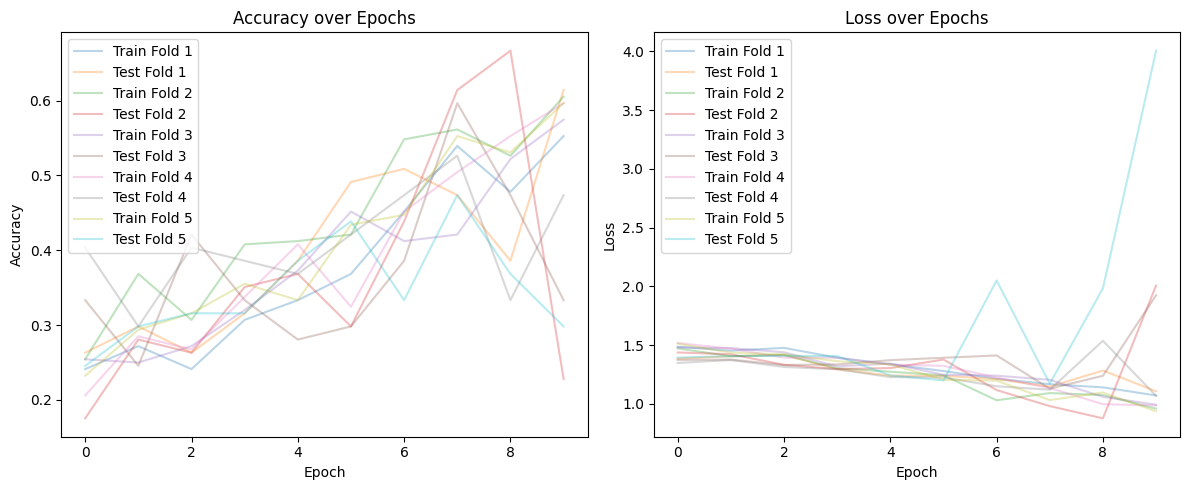

In [12]:
# Plot results
plt.figure(figsize=(12, 5))

# Plot accuracies
plt.subplot(1, 2, 1)
for fold in range(len(train_accuracies)):
    plt.plot(train_accuracies[fold], label=f'Train Fold {fold+1}', alpha=0.3)
    plt.plot(test_accuracies[fold], label=f'Test Fold {fold+1}', alpha=0.3)
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot losses
plt.subplot(1, 2, 2)
for fold in range(len(train_losses)):
    plt.plot(train_losses[fold], label=f'Train Fold {fold+1}', alpha=0.3)
    plt.plot(test_losses[fold], label=f'Test Fold {fold+1}', alpha=0.3)
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()